In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random
import matplotlib.patches as mpatches
import math

In [5]:
random.seed(10)

In [159]:
def filter_ko(gr_measured_ML, y, a_per, b_per):
    #classify gr

    a = np.percentile(gr_measured_ML['0'], a_per)
    b = np.percentile(gr_measured_ML['0'], b_per)

    y_t = []
    for i in gr_measured_ML['0']:
        if i < a:
            y_t.append(0)
        elif i>a and i<b:
            y_t.append(1)
        else:
            y_t.append(2)

    gr_measured_ML['class'] = y_t

    a = np.percentile(y['SM'], a_per)
    b = np.percentile(y['SM'], b_per)

    y_p = []
    for i in y['SM']:
        if i < a:
            y_p.append(0)
        elif i>a and i<b:
            y_p.append(1)
        else:
            y_p.append(2)

    y['class'] = y_p

    #filter medium gr KOs

    gr_measured_ML = gr_measured_ML[gr_measured_ML['class'] != 1]
    y = y[y['class'] != 1]

    return [gr_measured_ML, y]

In [160]:
def generate_combined_dataset(t, p, fluxes_t, fluxes_p):

    X = pd.concat([t, fluxes_t, p, fluxes_p], axis=1)
    X.columns = X.columns.astype(str)
    # X.dropna(inplace=True)

    return X

def split_data(X, y):
    #train, test, validation split

    test_size = int(0.3*y.shape[0])
    train_size = int(0.8*(y.shape[0] - test_size))
    valid_size = int(0.2*(y.shape[0] - test_size))


    y_train = y.groupby('class', group_keys=False).apply(lambda x: x.sample(n=train_size//2, random_state=42))

    train_valid = y.loc[list(set(y.index).difference(set(y_train.index))), :]
    y_valid = train_valid.groupby('class', group_keys=False).apply(lambda x: x.sample(n=valid_size//2, random_state=42))

    y_test = y.loc[list(set(y.index).difference(set(y_valid.index).union(set(y_train.index)))), :]


    return [y_train, y_test, y_valid]

fluxomics analysis

In [4]:
t = pd.read_csv('../data/compare_transcriptome.csv')
p = pd.read_csv('../data/compare_proteome.csv')

t.index = t['Unnamed: 0']
p.index = p['Unnamed: 0']
p.dropna(inplace=True)
t = t.iloc[:, 1:]
p = p.iloc[:, 2:]

eflux_t = pd.read_csv("../fluxomics/fluxes/gr_glpk.csv", header=None)
eflux_t = eflux_t.T

eflux_p = pd.read_csv("../fluxomics/fluxes/gr_p_glpk_seed1.csv", header=None)
eflux_p = eflux_p.T

gr_measured_ML = pd.read_csv('../data/compare_transcriptome_measured_gr.csv')
gr_measured_ML.index = t.index

y = pd.read_csv('../data/compare_measured_gr.csv')
y.index = y['ORF PROT']

fluxes_p = pd.read_csv('../fluxomics/fluxes/Fluxes_glpk_seed1.csv', header=None)
fluxes_p = fluxes_p.T
fluxes_p.index = p.index 

fluxes_t = pd.read_csv('../fluxomics/fluxes/Fluxes_t_glpk_seed1.csv', header=None)
fluxes_t  = fluxes_t.T
fluxes_t.index = t.index

fluxes_p = (fluxes_p - fluxes_p.min()) / (fluxes_p.max() - fluxes_p.min())

fluxes_t = (fluxes_t - fluxes_t.min()) / (fluxes_t.max() - fluxes_t.min())

    #remove the NaN columns from the normalized fluxomics dataframe
fluxes_p.dropna(axis=1, inplace=True)
fluxes_t.dropna(axis=1, inplace=True)

Predicted vs measured growth rate (EFlux algorithm using transcriptomics data) 

Text(0.4, 0.1, 'Spearman Correlation = 0.32')

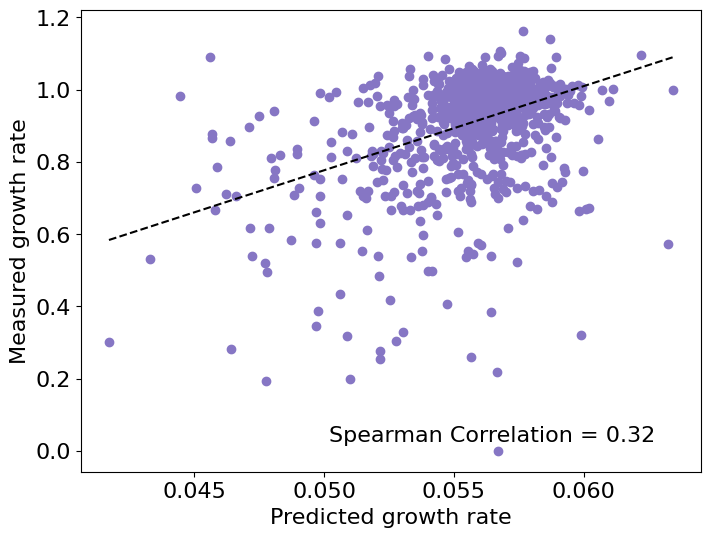

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(eflux_p[0], y.loc[p.index, 'SM'], c='#8676c4')
plt.plot(np.unique(eflux_p[0]), np.poly1d(np.polyfit(eflux_p[0], y.loc[p.index, 'SM'], 1))
         (np.unique(eflux_p[0])), '--k')
plt.ylabel("Measured growth rate", fontsize=16)
plt.xlabel("Predicted growth rate",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.text(0.4, 0.1, f"Spearman Correlation = {stats.spearmanr(eflux_p[0], y.loc[p.index, 'SM']).statistic:.2f}", transform=plt.gca().transAxes,
         fontsize=16, verticalalignment='top')

Predicted vs measured growth rate (EFlux algorithm using proteomics data) 

Text(0.4, 0.8, 'Spearman Correlation = -0.48')

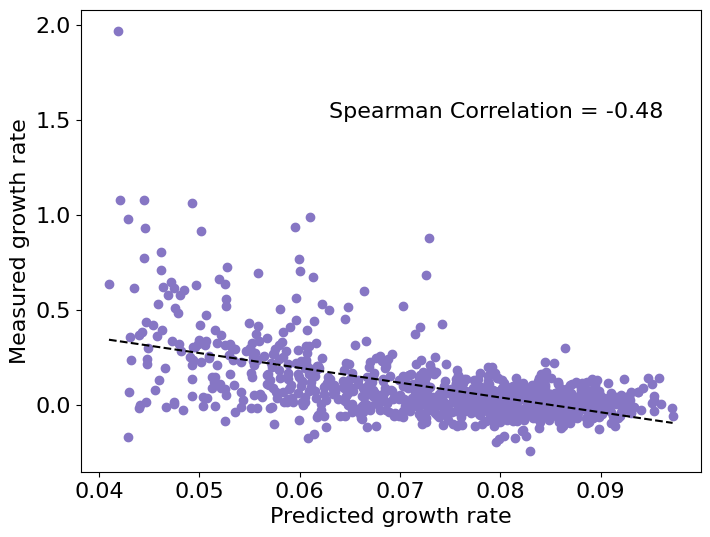

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(eflux_t[0], gr_measured_ML['0'], c='#8676c4')
plt.plot(np.unique(eflux_t[0]), np.poly1d(np.polyfit(eflux_t[0], gr_measured_ML['0'], 1))
         (np.unique(eflux_t[0])), '--k')
plt.ylabel("Measured growth rate", fontsize=16)
plt.xlabel("Predicted growth rate",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.text(0.4, 0.8, f"Spearman Correlation = {stats.spearmanr(eflux_t[0], gr_measured_ML['0']).statistic:.2f}", transform=plt.gca().transAxes,
         fontsize=16, verticalalignment='top')

In [27]:
# 10 random common indices in transcriptomics and proteomics datasets

indices = [list(set(t.index).intersection(p.index))[random.randint(0, 990)] for _ in range(10)]

Fluxomics profiles of 10 random samples

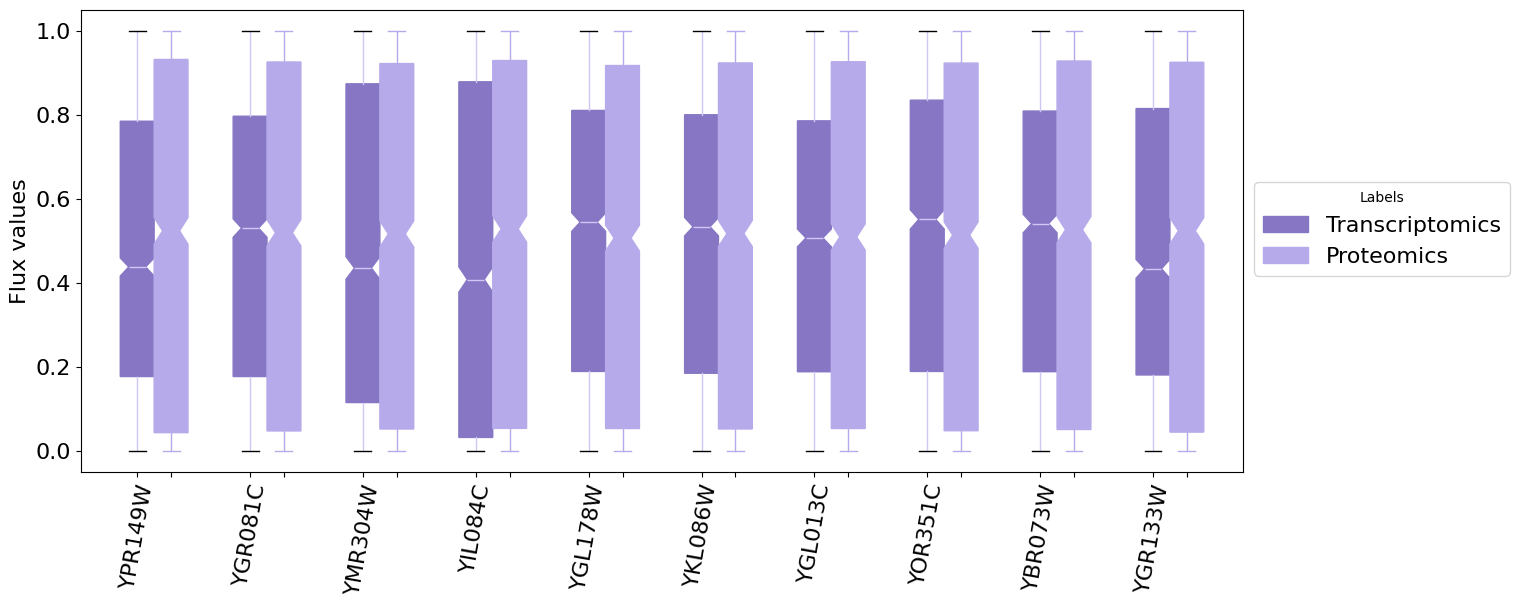

In [80]:
vals_t = []
vals_p = []
for i in indices:
    vals_t.append(fluxes_t.loc[i, :].values)
    vals_p.append(fluxes_p.loc[i, :].values)

plt.figure(figsize=(15,6))
# option 1, specify props dictionaries
plt.boxplot(vals_t, positions=[i + 0.2 for i in range(10)], notch=True, patch_artist=True, widths=0.3, tick_labels=[i for i in indices], boxprops=dict(color='#8676c4', facecolor='#8676c4'), whiskerprops=dict(color='#d1c7f7'), medianprops=dict(color='#d1c7f7'))


# option 2, set all colors individually
c2 = "purple"
box1 = plt.boxplot(vals_p, positions=[i + 0.5 for i in range(10)], notch=True, patch_artist=True, widths=0.3, tick_labels=["" for _ in range(10)], boxprops=dict(color='#b7aaea', facecolor='#b7aaea'), whiskerprops=dict(color='#d1c7f7'), medianprops=dict(color='#d1c7f7'))

for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box1[item], color='#b7aaea')
plt.setp(box1["boxes"], facecolor='#b7aaea')
plt.setp(box1["fliers"], markeredgecolor='#b7aaea')

plt.xticks(rotation=80, size=16)
plt.yticks(size=16)
plt.ylabel("Flux values", size=16)

legend_patches = [
    mpatches.Patch(color='#8676c4', label='Transcriptomics'),
    mpatches.Patch(color='#b7aaea', label='Proteomics')
]

plt.legend(handles=legend_patches, title='Labels', loc='lower left',  bbox_to_anchor=(1, 0.4), fontsize=16)

plt.show()

In [6]:
rxns = pd.read_csv("../data/model_reactions.csv", header=None)

Correlation coefficient of the fluxes with the measured growth rate

/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_38089/2704262840.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  val = stats.pearsonr(gr_measured_ML['0'], fluxes_t.loc[:, i]).correlation
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_38089/2704262840.py:19: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  val = stats.pearsonr(y.loc[fluxes_p.index, 'SM'], fluxes_p.loc[:, i]).correlation
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_38089/2704262840.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  val = stats.pearsonr(gr_measured_ML['0'], fluxes_t.loc[:, i]).correlation
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_38089/2704262840.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  val = stats.pearsonr(y.loc[fluxes_p.index, 'SM'], flux

Text(0.4, 0.1, 'Spearman Correlation = 0.39')

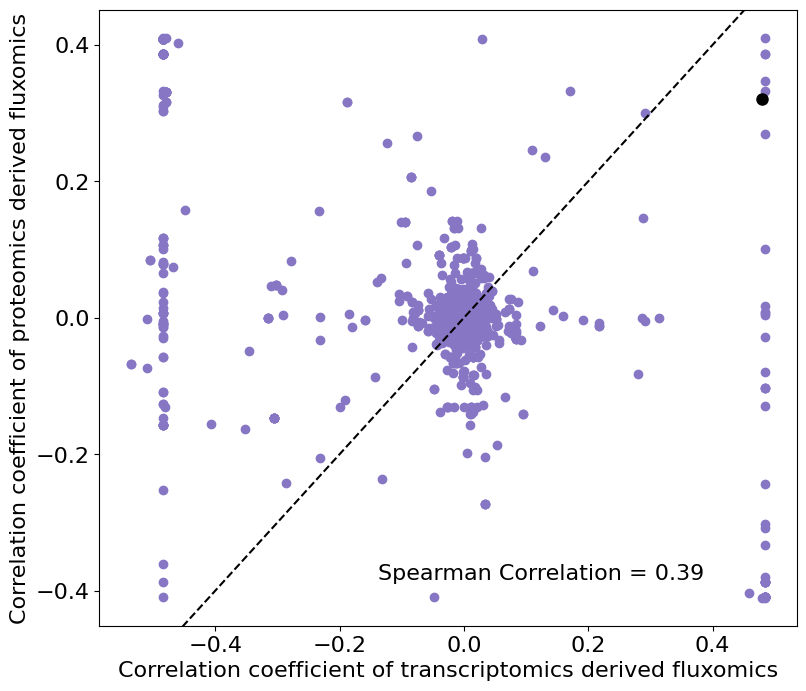

In [23]:
fluxes_p = pd.read_csv('../fluxomics/fluxes/Fluxes_glpk_seed1.csv', header=None)
fluxes_p = fluxes_p.T
fluxes_p.index = p.index 

fluxes_t = pd.read_csv('../fluxomics/fluxes/Fluxes_t_glpk_seed1.csv', header=None)
fluxes_t  = fluxes_t.T
fluxes_t.index = t.index

corr = {}
for i in fluxes_t.columns:
    val = stats.pearsonr(gr_measured_ML['0'], fluxes_t.loc[:, i]).correlation
    corr[i] = val
keys = list(corr.keys())
values = [i for i in corr.values()]
corr_t = {rxns[0][keys[i]]: values[i] for i in range(len(keys))}

corr = {}
for i in fluxes_p.columns:
    val = stats.pearsonr(y.loc[fluxes_p.index, 'SM'], fluxes_p.loc[:, i]).correlation
    corr[i] = val
corr

keys = list(corr.keys())
values = [i for i in corr.values()]
corr_p = {rxns[0][keys[i]]: values[i] for i in range(len(keys))}

plt.figure(figsize=(9, 8))
plt.scatter(corr_t.values(), corr_p.values(), color='#8676c4')
plt.plot([0.48], [0.32], 'ko', linewidth=4, markersize=8)
plt.xlabel("Correlation coefficient of transcriptomics derived fluxomics", size=16)
plt.ylabel("Correlation coefficient of proteomics derived fluxomics", size=16)
xpoints = ypoints = plt.xlim()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(xpoints, ypoints, linestyle='--', color='k', scalex=False, scaley=False)

corr = {}
for i in fluxes_t.columns:
    val = stats.pearsonr(gr_measured_ML['0'], fluxes_t.loc[:, i]).correlation
    if not np.isnan(val):
        corr[i] = val
keys = list(corr.keys())
values = [abs(i) for i in corr.values()]
corr_t = {rxns[0][keys[i]]: values[i] for i in range(len(keys))}

corr = {}
for i in fluxes_p.columns:
    val = stats.pearsonr(y.loc[fluxes_p.index, 'SM'], fluxes_p.loc[:, i]).correlation
    if not np.isnan(val):
        corr[i] = val
keys = list(corr.keys())
values = [abs(i) for i in corr.values()]
corr_p = {rxns[0][keys[i]]: values[i] for i in range(len(keys))}

plt.text(0.4, 0.1, f"Spearman Correlation = {stats.spearmanr([corr_t[i] for i in list(set(corr_t.keys()).intersection(corr_p.keys()))], [corr_p[i] for i in list(set(corr_t.keys()).intersection(corr_p.keys()))]).statistic:.2f}", transform=plt.gca().transAxes,
         fontsize=16, verticalalignment='top')

Statistics of the gene and protein measurements

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.05, '0.05'),
  Text(0, 0.1, '0.10'),
  Text(0, 0.15000000000000002, '0.15'),
  Text(0, 0.2, '0.20'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.30000000000000004, '0.30'),
  Text(0, 0.35000000000000003, '0.35'),
  Text(0, 0.4, '0.40')])

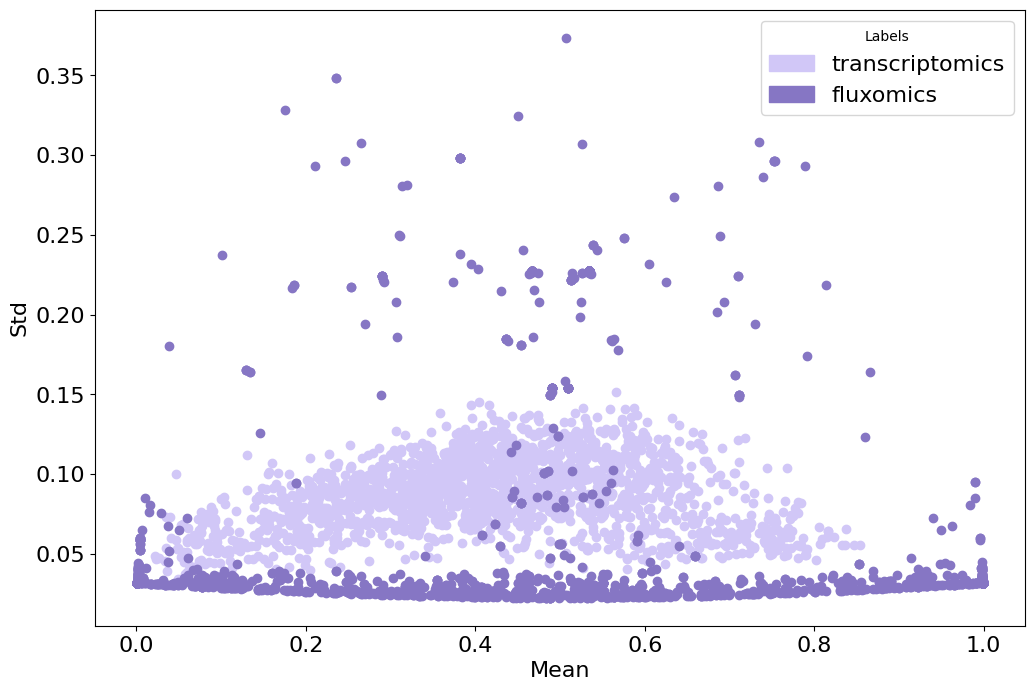

In [156]:
p = (p - p.min())/(p.max() - p.min())
t = (t - t.min())/(t.max() - t.min())

plt.figure(figsize=(12, 8))
plt.scatter(t.mean(), t.std(), c='#d1c7f7')
plt.scatter(fluxes_t.mean(), fluxes_t.std(), c='#8676c4')
plt.xlabel("Mean", fontsize=16)
plt.ylabel("Std", fontsize=16)
legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='transcriptomics'),
    mpatches.Patch(color='#8676c4', label='fluxomics')
]
plt.legend(handles=legend_patches, title='Labels', loc='upper right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5')])

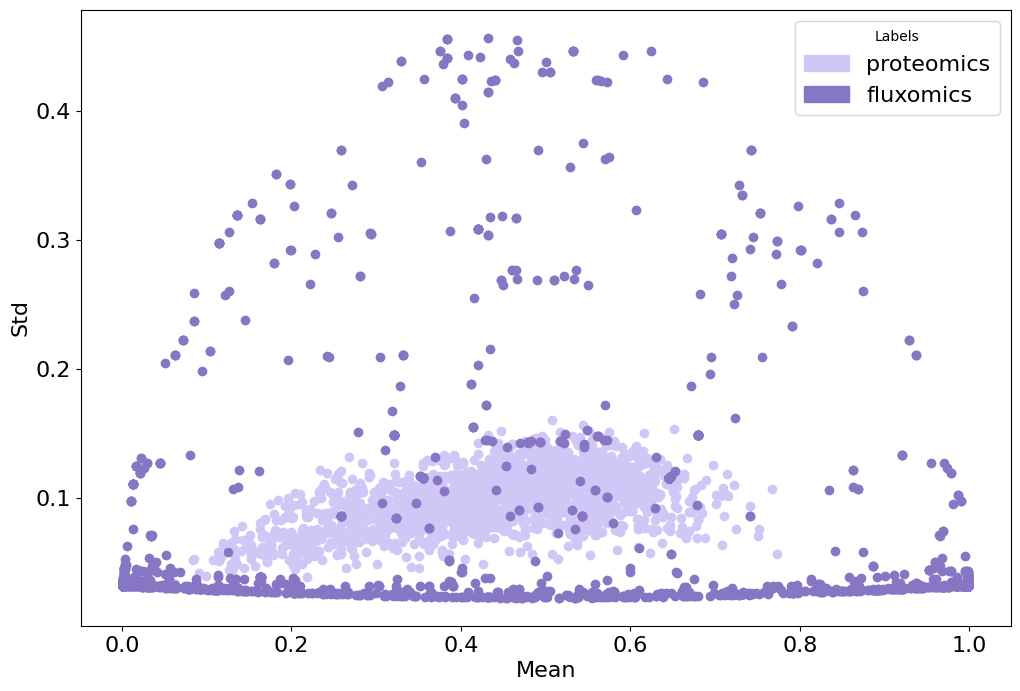

In [157]:
plt.figure(figsize=(12, 8))
plt.scatter(p.mean(), p.std(), c='#d1c7f7')
plt.scatter(fluxes_p.mean(), fluxes_p.std(), c='#8676c4')
plt.xlabel("Mean", fontsize=16)
plt.ylabel("Std", fontsize=16)
legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='proteomics'),
    mpatches.Patch(color='#8676c4', label='fluxomics')
]
plt.legend(handles=legend_patches, title='Labels', loc='upper right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [161]:
[gr_measured_ML, y] = filter_ko(gr_measured_ML, y, 30, 70)

X = generate_combined_dataset(t, p, fluxes_t, fluxes_p)

X_t = X.filter(items=gr_measured_ML.index, axis=0)
X_p = X.filter(items=y.index, axis=0)

gr_measured_ML =  gr_measured_ML.filter(items=X_t.index, axis=0)
y =  y.filter(items=X_p.index, axis=0)

[y_train_liq, y_test_liq, y_valid_liq] = split_data(X_t, gr_measured_ML)
X_train_liq = X_t.loc[y_train_liq.index, :]
X_test_liq = X_t.loc[y_test_liq.index, :]
X_valid_liq = X_t.loc[y_valid_liq.index, :]

y_valid_liq = y_valid_liq['class']
y_train_liq = y_train_liq['class']
y_test_liq = y_test_liq['class']

[y_train_solid, y_test_solid, y_valid_solid] = split_data(X_p, y)
X_train_solid = X_p.loc[y_train_solid.index, :]
X_test_solid = X_p.loc[y_test_solid.index, :]
X_valid_solid = X_p.loc[y_valid_solid.index, :]

y_train_solid = y_train_solid['class']
y_test_solid = y_test_solid['class']
y_valid_solid = y_valid_solid['class']

/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_53848/95334531.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_train = y.groupby('class', group_keys=False).apply(lambda x: x.sample(n=train_size//2, random_state=42))
/var/folders/1g/phgxzfj511q1zyh71ggb7hxw0000gq/T/ipykernel_53848/95334531.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_valid = train_valid.groupby('class', group_keys

Heatmap of expression and fluxomics values under the 30-70th percentile split

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(2255.555555555556, 0.5, 'Samples')

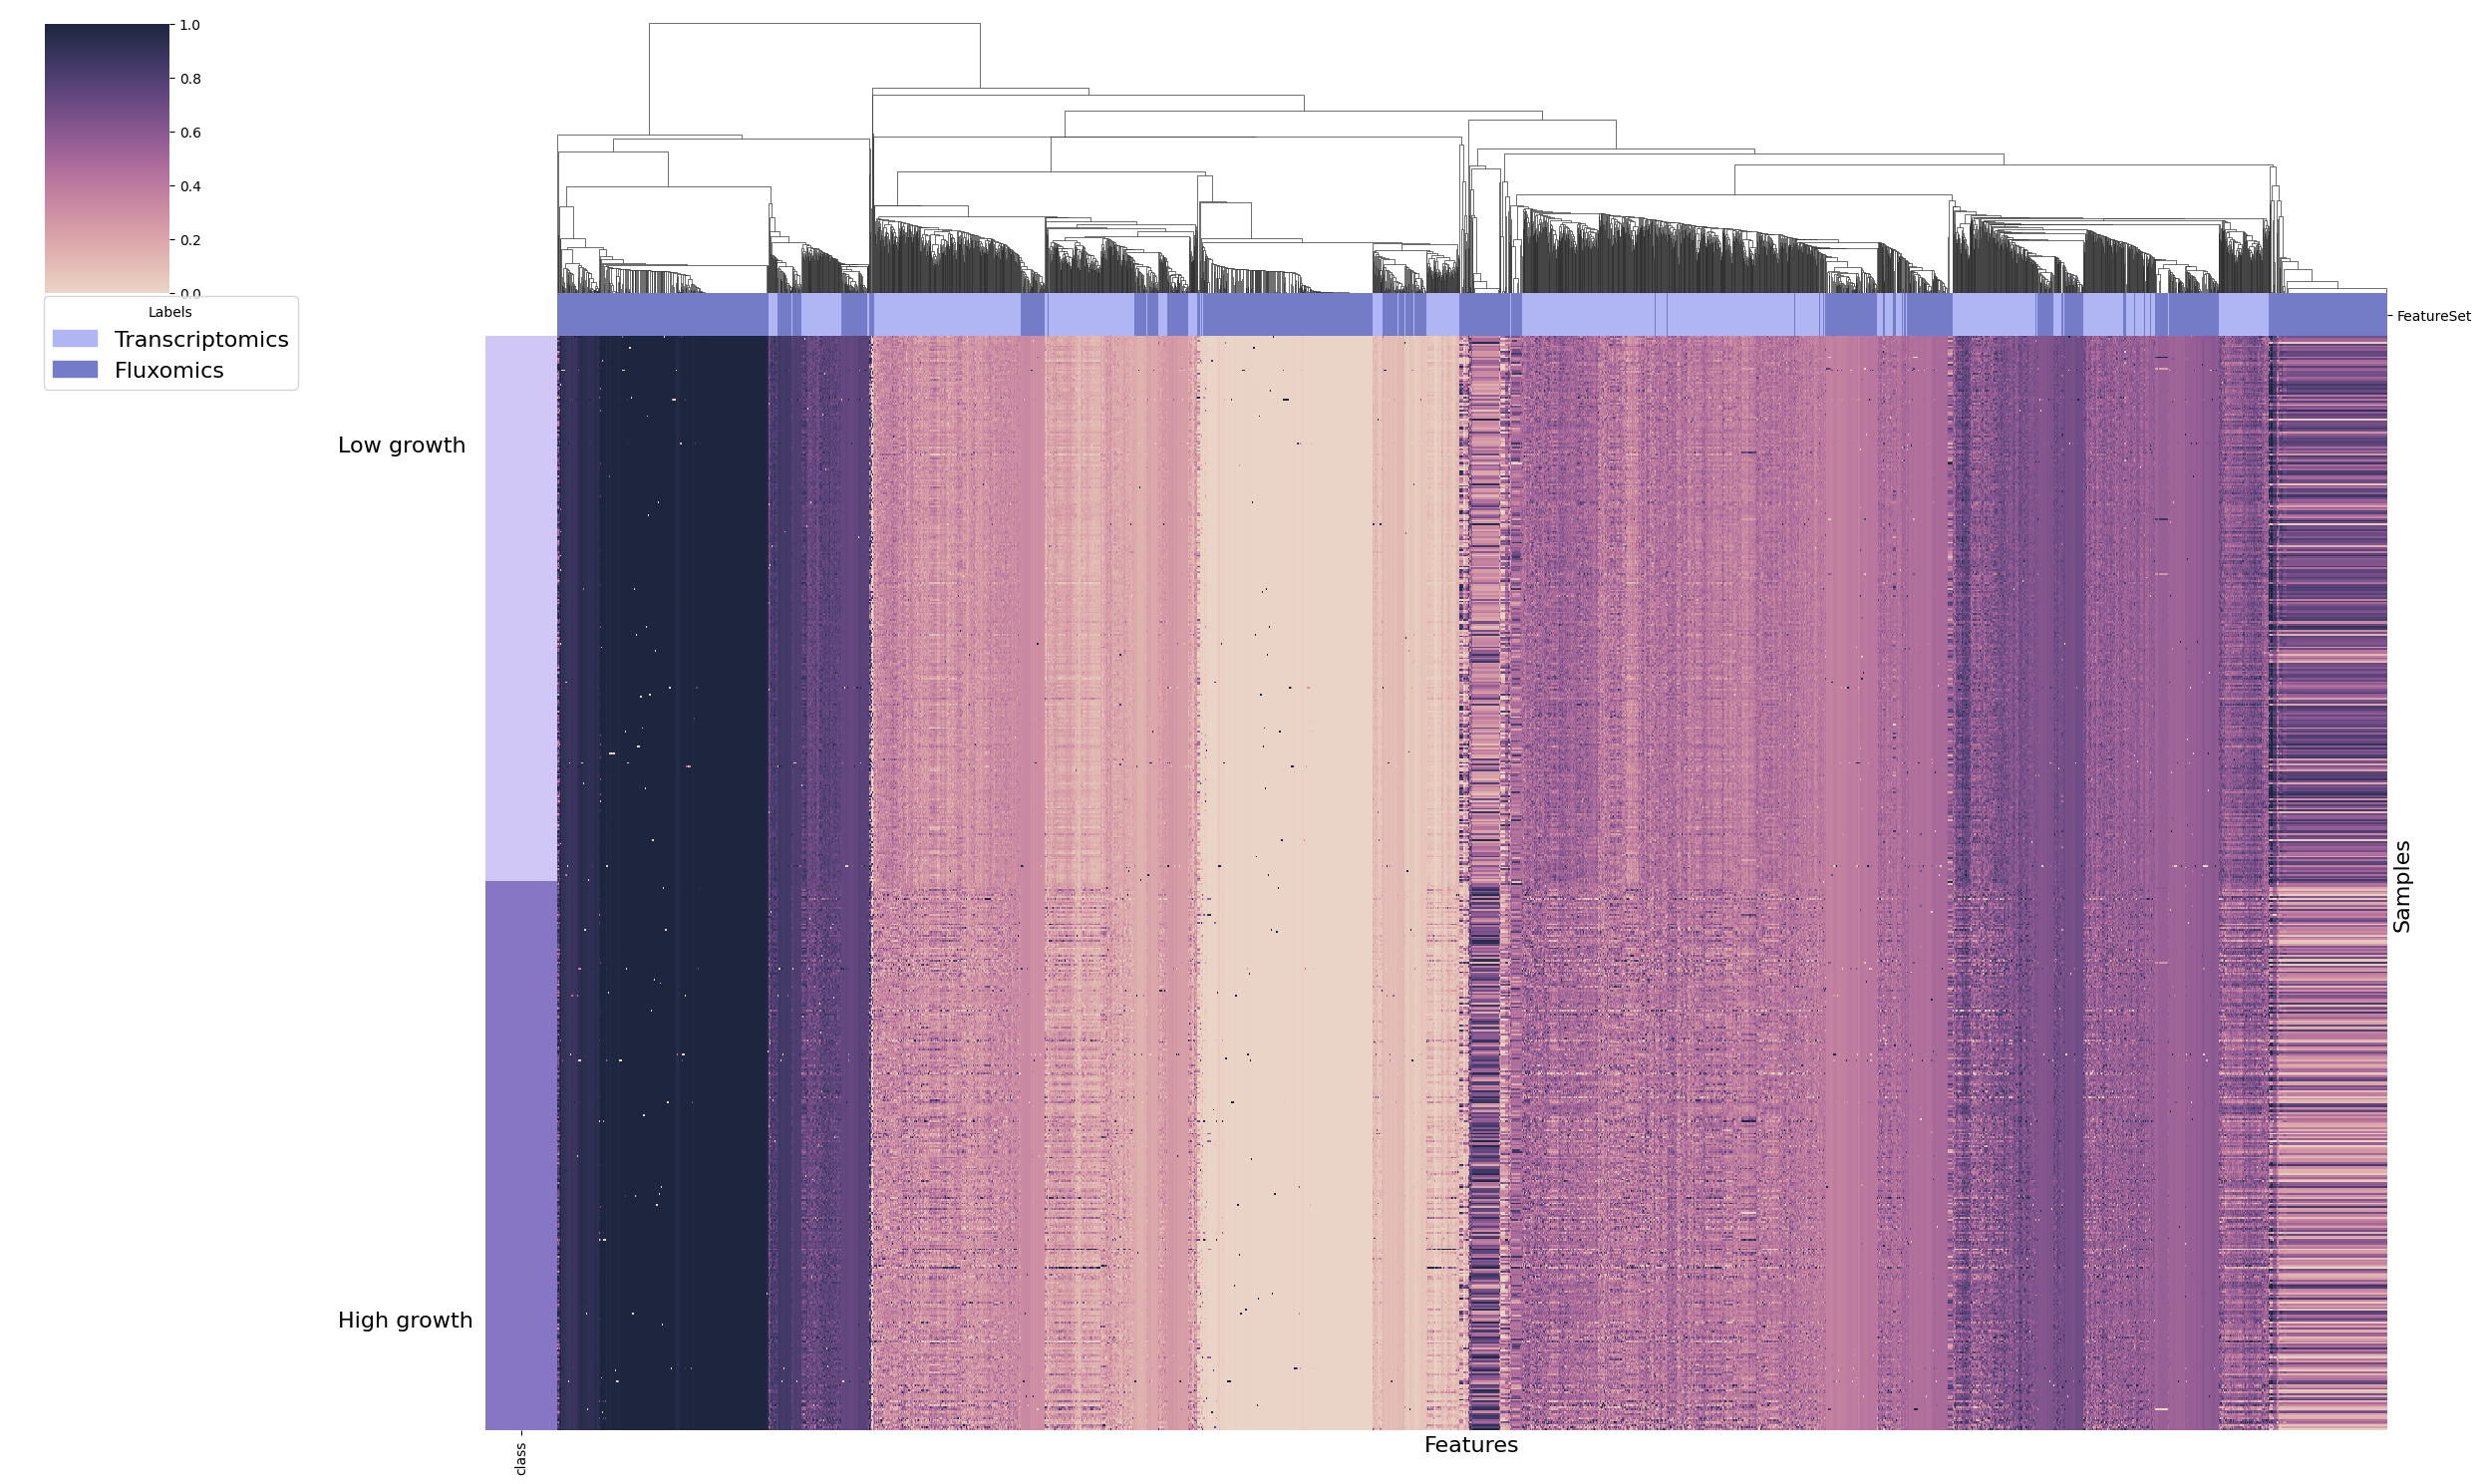

In [162]:
index = gr_measured_ML['class'].sort_values().index
data = pd.concat([t, fluxes_t], axis=1)
cols = ['transcriptomics' if i < 1827 else 'fluxomics' for i in range(data.shape[1])]
col_colors = pd.Series(cols, index=data.columns).map({
    'transcriptomics': '#afb6f3',
    'fluxomics': '#747cc8'
})
g = sns.clustermap(data.loc[index, :], row_colors=gr_measured_ML.loc[index, 'class'].map({0: '#d1c7f7', 2: '#8676c4'}),
                 col_colors=pd.DataFrame({'FeatureSet': col_colors}),
                 figsize=(25, 15), cmap=sns.color_palette("ch:s=-.4,r=.6", as_cmap=True), 
                row_cluster=False,
                xticklabels=False,
    yticklabels=False)


legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='Low growth'),
    mpatches.Patch(color='#8676c4', label='High growth')
]
legend_patches_2 = [
    mpatches.Patch(color='#afb6f3', label='Transcriptomics'),
    mpatches.Patch(color='#747cc8', label='Fluxomics')
]
ax = g.ax_heatmap

# Add labels for the row colors (Low/High growth)
# Position depends on your plot size and how many samples you have
ax.text(-0.12, 0.9, 'Low growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')
ax.text(-0.12, 0.1, 'High growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')

plt.legend(handles=legend_patches_2, title='Labels', loc='lower left',  bbox_to_anchor=(-0.1, -0.4), fontsize=16)

# Remove default legend if present
if g.ax_col_dendrogram.legend_:
    g.ax_col_dendrogram.legend_.remove()

g.ax_heatmap.set_xlabel("Features", fontsize=16)
g.ax_heatmap.set_ylabel("Samples", fontsize=16)

/Users/birdslab/Desktop/Krithikaa/fluxes/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(2255.555555555556, 0.5, 'Samples')

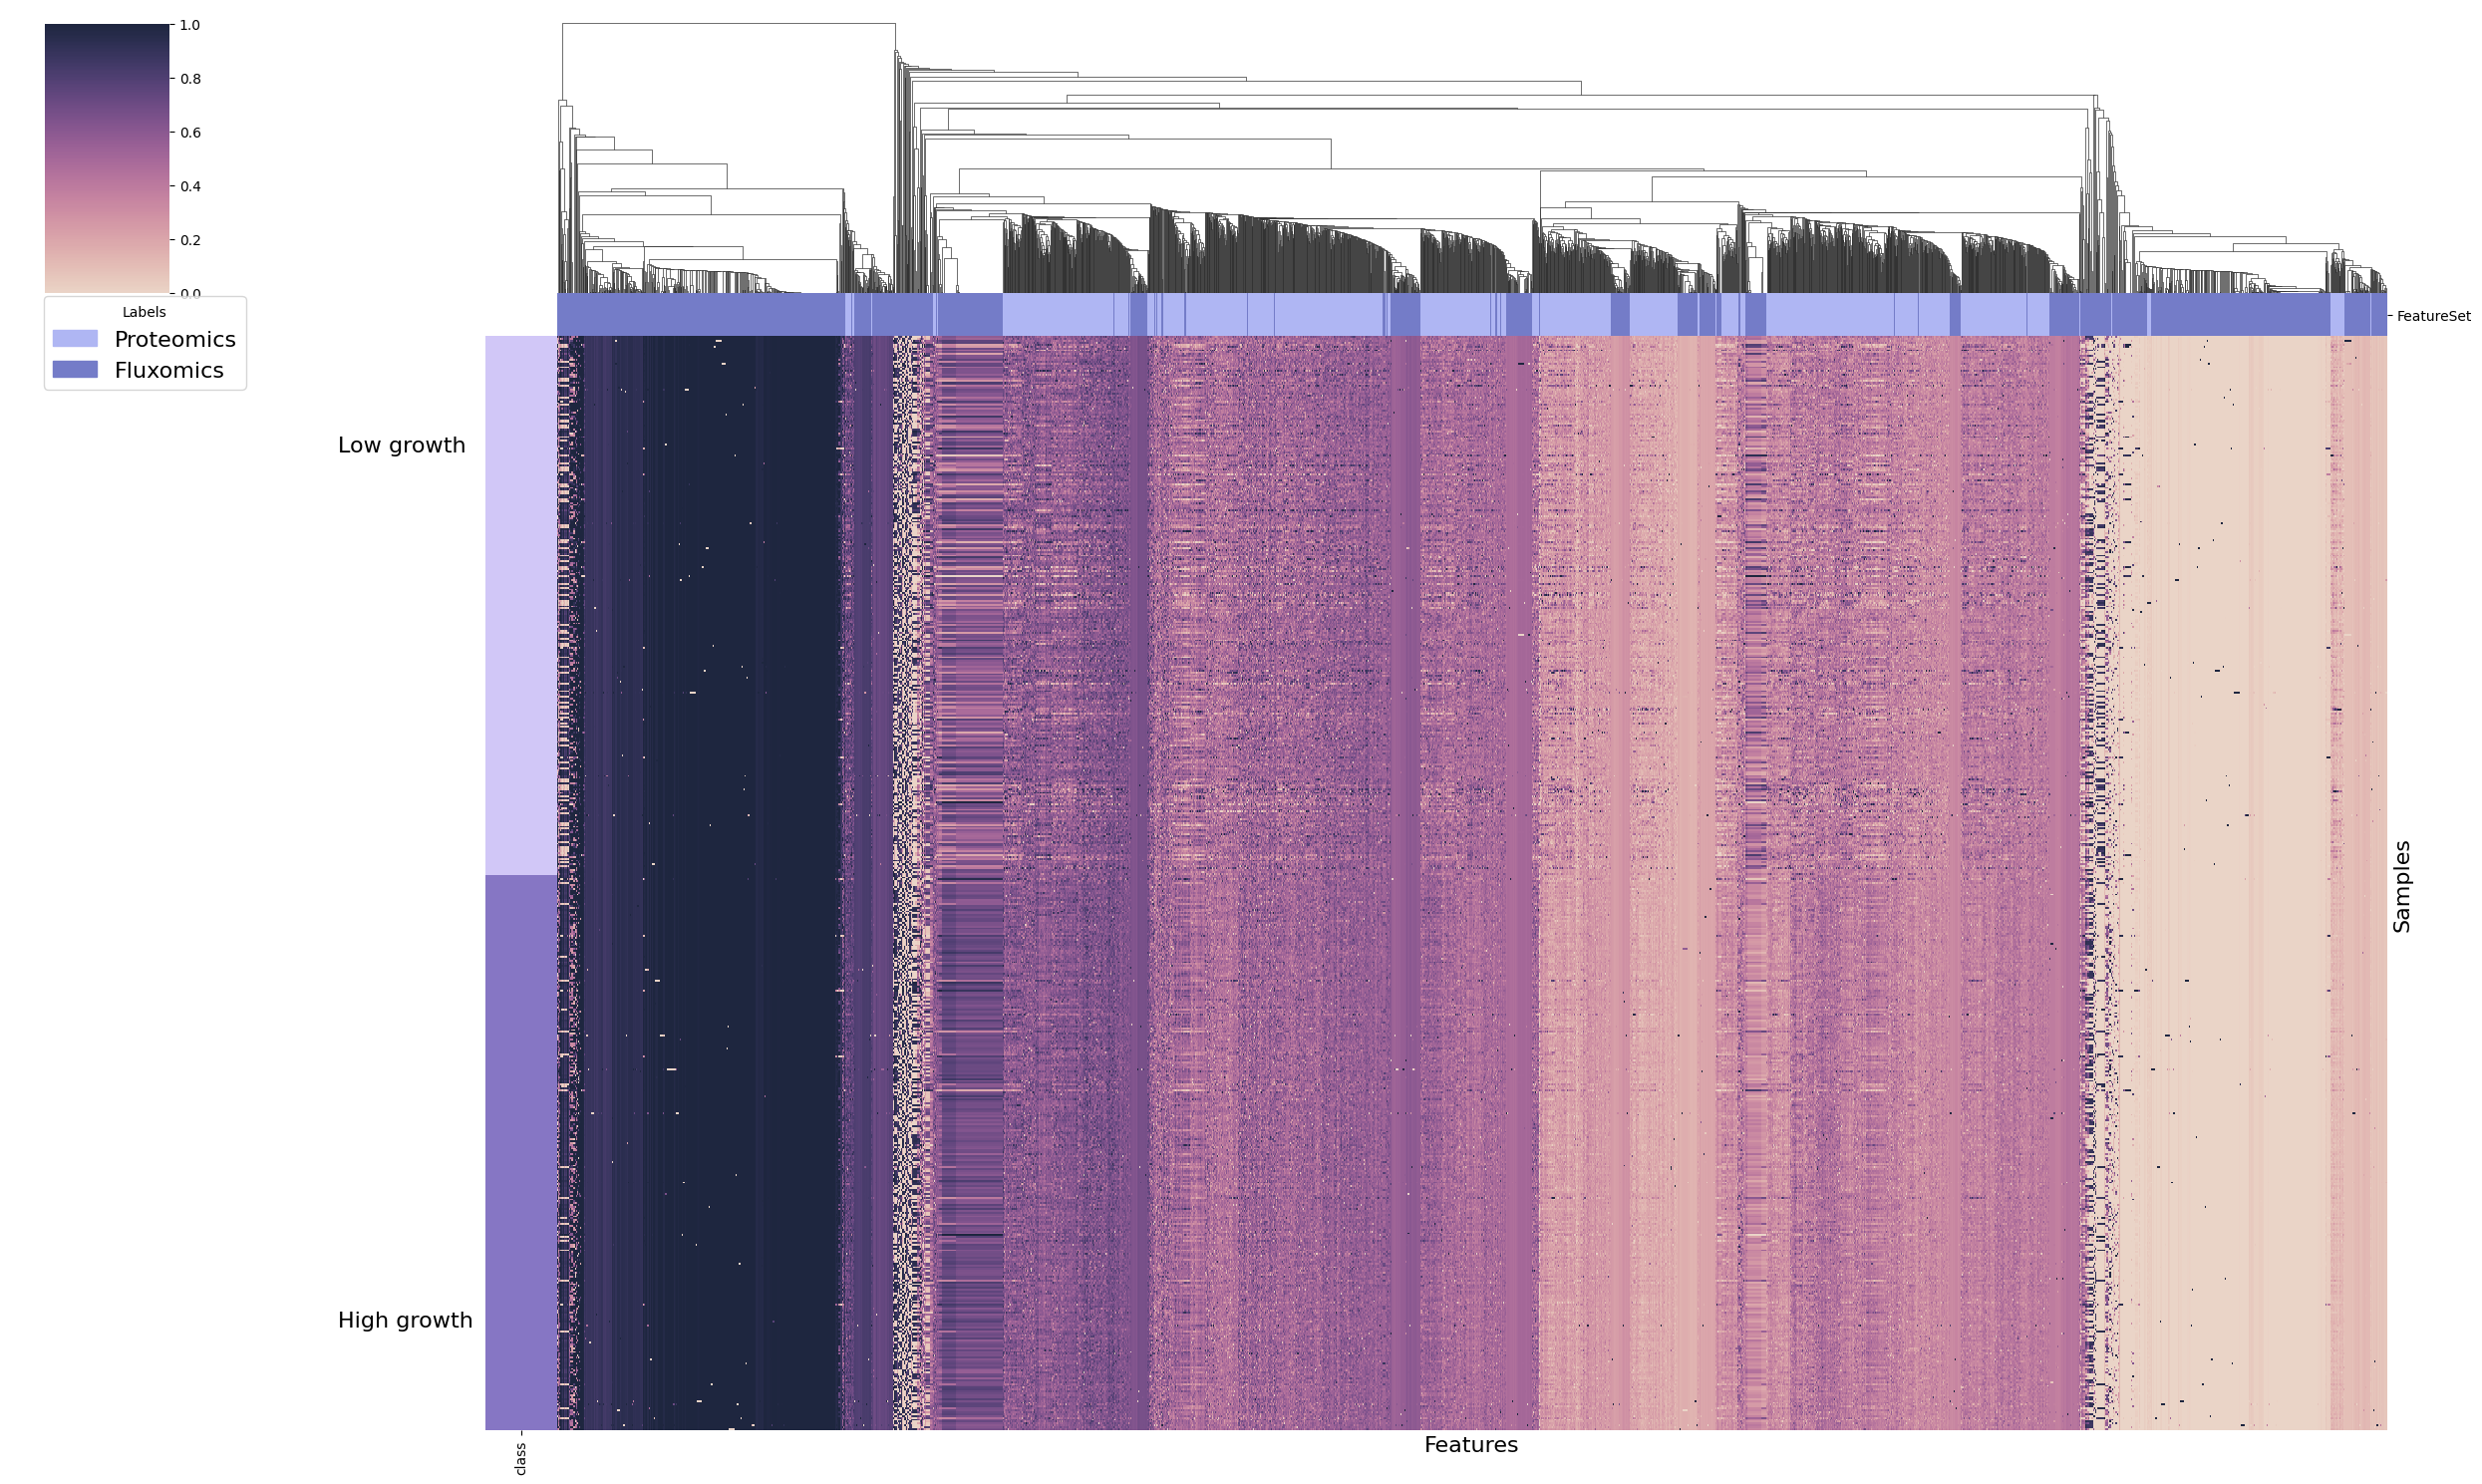

In [163]:
index = y['class'].sort_values().index
data = pd.concat([p, fluxes_p], axis=1)
data.dropna(axis=0, inplace=True)
cols = ['proteomics' if i < 1827 else 'fluxomics' for i in range(data.shape[1])]
col_colors = pd.Series(cols, index=data.columns).map({
    'proteomics': '#afb6f3',
    'fluxomics': '#747cc8'
})
index = list(set(index).intersection(set(data.index)))
index = y.loc[index, 'class'].sort_values().index
g = sns.clustermap(data.loc[index, :], row_colors=y.loc[index, 'class'].map({0: '#d1c7f7', 2: '#8676c4'}),
                 col_colors=pd.DataFrame({'FeatureSet': col_colors}),
                 figsize=(25, 15), cmap=sns.color_palette("ch:s=-.4,r=.6", as_cmap=True), 
                row_cluster=False,
                xticklabels=False,
    yticklabels=False)


legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='Low growth'),
    mpatches.Patch(color='#8676c4', label='High growth')
]
legend_patches_2 = [
    mpatches.Patch(color='#afb6f3', label='Proteomics'),
    mpatches.Patch(color='#747cc8', label='Fluxomics')
]
ax = g.ax_heatmap

# Add labels for the row colors (Low/High growth)
# Position depends on your plot size and how many samples you have
ax.text(-0.12, 0.9, 'Low growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')
ax.text(-0.12, 0.1, 'High growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')

plt.legend(handles=legend_patches_2, title='Labels', loc='lower left',  bbox_to_anchor=(-0.1, -0.4), fontsize=16)

# Remove default legend if present
if g.ax_col_dendrogram.legend_:
    g.ax_col_dendrogram.legend_.remove()

g.ax_heatmap.set_xlabel("Features", fontsize=16)
g.ax_heatmap.set_ylabel("Samples", fontsize=16)

Plots showing the statistics of the machine learning model

In [27]:
stats = pd.read_csv("../machine learning/results/statistics.csv")
stats.index = stats['Unnamed: 0'].values
stats.drop(columns=['Unnamed: 0'], inplace=True)
stats

R2 Score       MAE      RMSE  MDAE  Spearman Correlation  \
SVM_T_10           0.799778  0.100000  0.447214   0.0              0.900500   
KNN_T_10           0.399333  0.300000  0.774597   0.0              0.721640   
LASSO_log_T_10     0.733037  0.133333  0.516398   0.0              0.868743   
Elasticnet_T_10    0.733037  0.133333  0.516398   0.0              0.868743   
SVM_T_F_10         0.799778  0.100000  0.447214   0.0              0.900500   
...                     ...       ...       ...   ...                   ...   
Elasticnet_P_50    0.071575  0.464164  0.963498   0.0              0.542361   
SVM_P_F_50        -0.215144  0.607509  1.102278   0.0              0.393072   
KNN_P_F_50        -0.597437  0.798635  1.263831   0.0              0.211772   
LASSO_log_P_F_50  -0.010345  0.505119  1.005106   0.0              0.497975   
Elasticnet_P_F_50  0.030615  0.484642  0.984522   0.0              0.519060   

                   Accuracy  Train Accuracy  Precision    Recall  F1-Score  
SVM_T_10           0.950000        1.000000   0.950556  0.950000  0.950014  
KNN_T_10           0.850000        1.000000   0.871065  0.850000  0.848531  
LASSO_log_T_10     0.933333        1.000000   0.935410  0.933333  0.933333  
Elasticnet_T_10    0.933333        1.000000   0.935410  0.933333  0.933333  
SVM_T_F_10         0.950000        1.000000   0.950556  0.950000  0.950014  
...                     ...             ...        ...       ...       ...  
Elasticnet_P_50    0.767918        0.966790   0.774932  0.767918  0.766151  
SVM_P_F_50         0.696246        1.000000   0.697125  0.696246  0.695700  
KNN_P_F_50         0.600683        0.750923   0.613049  0.600683  0.587422  
LASSO_log_P_F_50   0.747440        0.948339   0.750920  0.747440  0.746322  
Elasticnet_P_F_50  0.757679        0.902214   0.761772  0.757679  0.756493  

[80 rows x 10 columns]

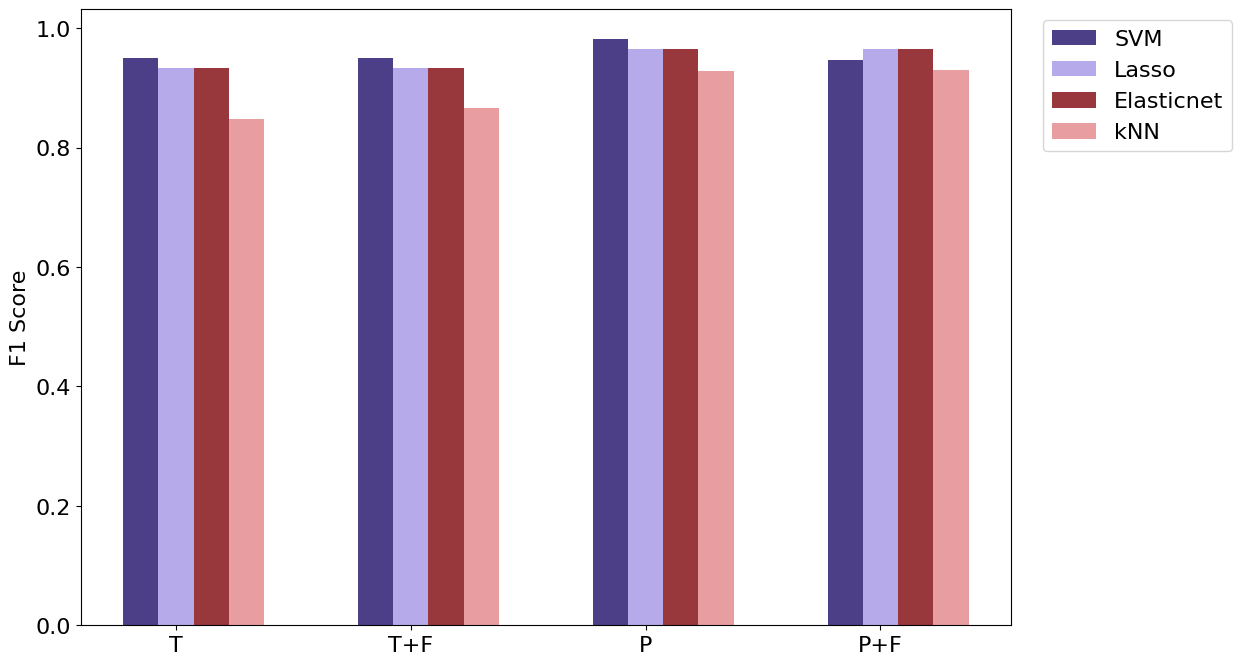

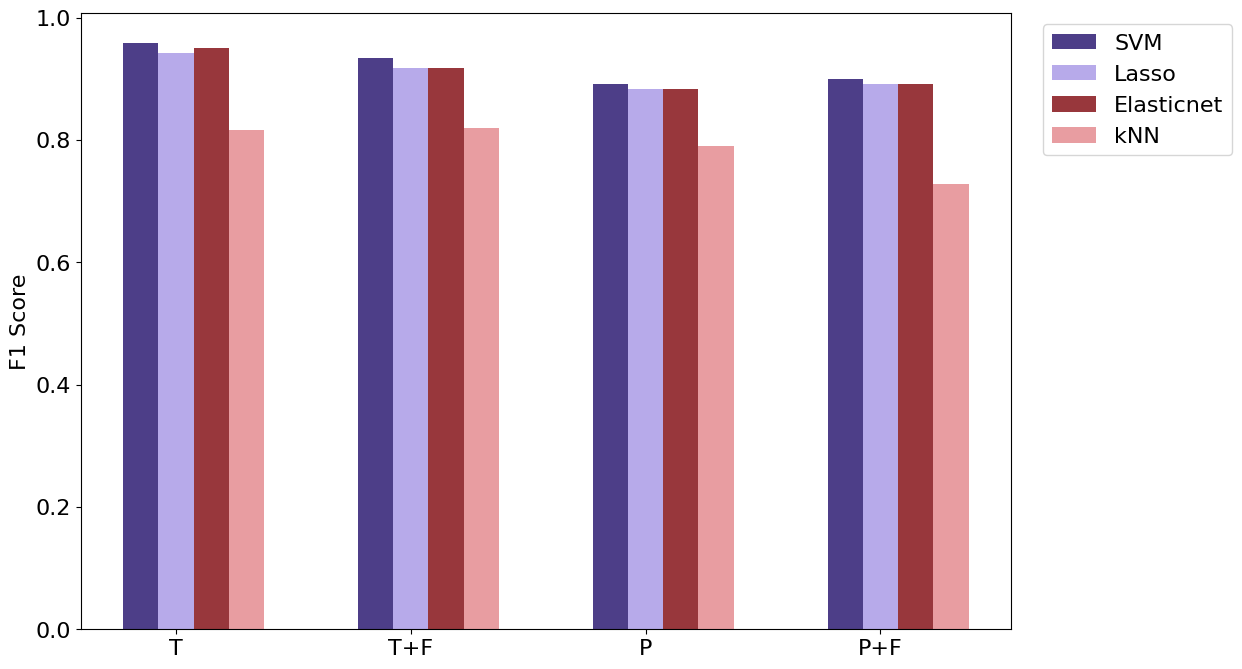

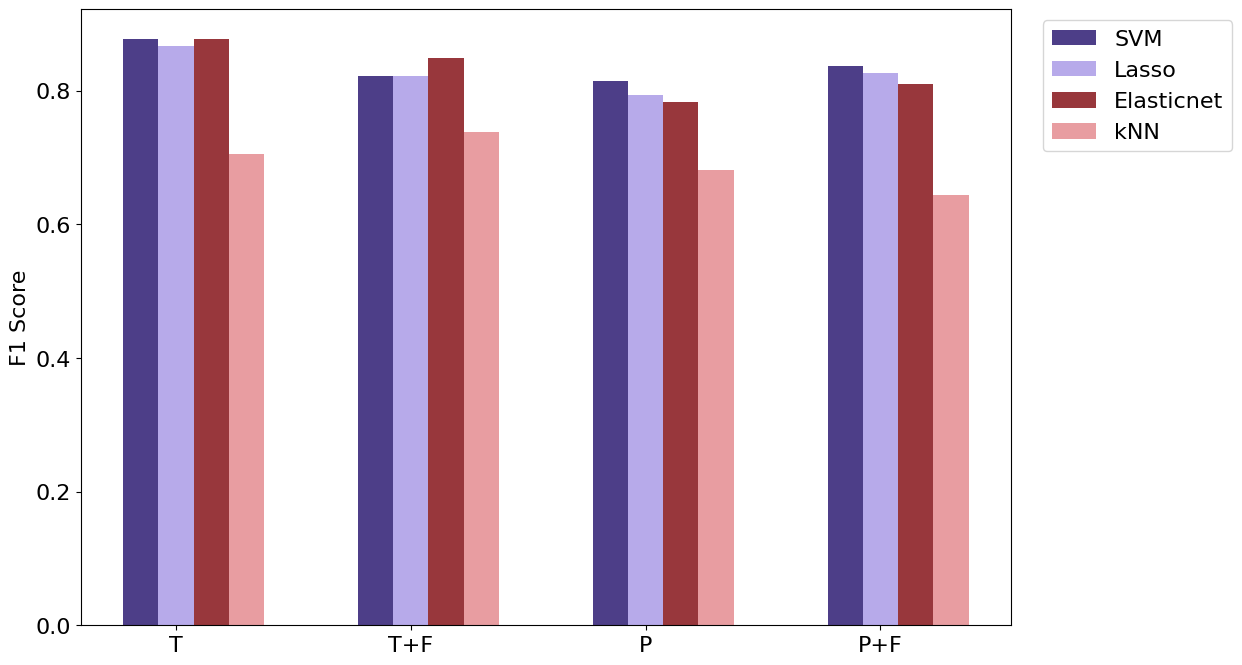

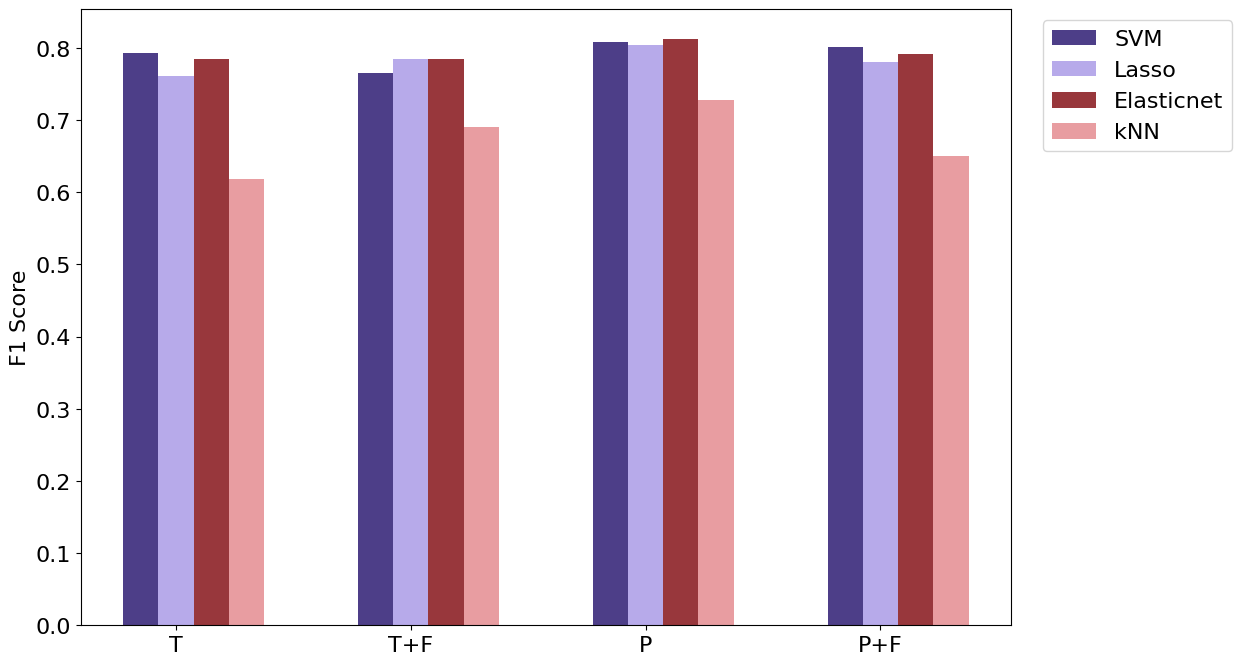

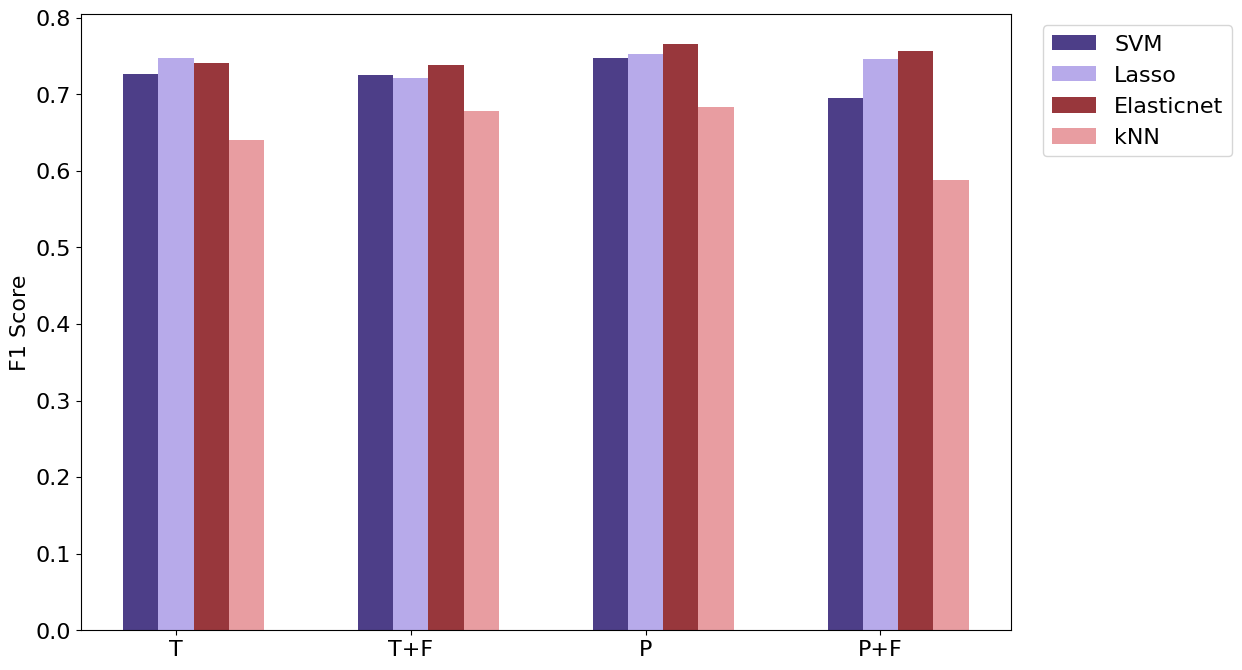

In [32]:
for split in ['10', '20', '30', '40', '50']:
    SVM = [stats.loc['SVM_'+i+'_'+split]['F1-Score'] for i in ['T', 'T_F', 'P', 'P_F']]
    Lasso = [stats.loc['LASSO_log_'+i+'_'+split]['F1-Score'] for i in ['T', 'T_F', 'P', 'P_F']]
    Elasticnet = [stats.loc['Elasticnet_'+i+'_'+split]['F1-Score'] for i in ['T', 'T_F', 'P', 'P_F']]
    kNN = [stats.loc['KNN_'+i+'_'+split]['F1-Score'] for i in ['T', 'T_F', 'P', 'P_F']]

    barWidth = 0.15
    br1 = np.arange(len(SVM)) 
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2] 
    br4 = [x + barWidth for x in br3] 

    plt.figure(figsize=(12, 8))
    plt.bar(br1, SVM, color ='#4d3e88', width = barWidth, label ='SVM') 
    plt.bar(br2, Lasso, color ='#b7aaea', width = barWidth, label ='Lasso') 
    plt.bar(br3, Elasticnet, color ='#98373c', width = barWidth, label ='Elasticnet') 
    plt.bar(br4, kNN, color ='#e89da1', width = barWidth, label ='kNN') 

    plt.ylabel('F1 Score', fontsize = 16) 
    plt.xticks([r + barWidth for r in range(len(SVM))], ['T', 'T+F', 'P', 'P+F'], fontsize=16)
    plt.yticks(fontsize=16)

    plt.legend(fontsize=16, loc='upper right', bbox_to_anchor=(1.25, 1.0))
    plt.show() 

In [164]:
stats_auc = pd.DataFrame()
stats_auc.index = [
    '10-90', '20-80', '30-70', '40-60', '50-50'
]

stats_auc['SVM_T'] = [1.00, 0.94, 0.90, 0.82, 0.73]
stats_auc['SVM_T_F'] = [1.00, 0.91, 0.87, 0.82, 0.75]

stats_auc['SVM_P'] = [0.93, 0.91, 0.86, 0.86, 0.76]
stats_auc['SVM_P_F'] = [0.89, 0.94, 0.89, 0.83, 0.69]

stats_auc['Lasso_T'] = [1.00, 0.91, 0.89, 0.79, 0.74]
stats_auc['Lasso_T_F'] = [0.96, 0.85, 0.84, 0.81, 0.73]

stats_auc['Lasso_P'] = [0.93, 0.91, 0.85, 0.84, 0.78]
stats_auc['Lasso_P_F'] = [0.89, 0.94, 0.88, 0.88, 0.78]

stats_auc['Elasticnet_T'] = [1.00, 0.91, 0.89, 0.83, 0.74]
stats_auc['Elasticnet_T_F'] = [0.96, 0.85, 0.83, 0.82, 0.73]

stats_auc['Elasticnet_P'] = [0.93, 0.91, 0.85, 0.88, 0.78]
stats_auc['Elasticnet_P_F'] = [0.89, 0.91, 0.86, 0.85, 0.78]

stats_auc['kNN_T'] = [0.96, 0.85, 0.70, 0.63, 0.62]
stats_auc['kNN_T_F'] = [0.96, 0.78, 0.76, 0.71, 0.68]

stats_auc['kNN_P'] = [0.92, 0.78, 0.70, 0.77, 0.67]
stats_auc['kNN_P_F'] = [0.85, 0.72, 0.64, 0.73, 0.59]

stats_auc

SVM_T  SVM_T_F  SVM_P  SVM_P_F  Lasso_T  Lasso_T_F  Lasso_P  Lasso_P_F  \
10-90   1.00     1.00   0.93     0.89     1.00       0.96     0.93       0.89   
20-80   0.94     0.91   0.91     0.94     0.91       0.85     0.91       0.94   
30-70   0.90     0.87   0.86     0.89     0.89       0.84     0.85       0.88   
40-60   0.82     0.82   0.86     0.83     0.79       0.81     0.84       0.88   
50-50   0.73     0.75   0.76     0.69     0.74       0.73     0.78       0.78   

       Elasticnet_T  Elasticnet_T_F  Elasticnet_P  Elasticnet_P_F  kNN_T  \
10-90          1.00            0.96          0.93            0.89   0.96   
20-80          0.91            0.85          0.91            0.91   0.85   
30-70          0.89            0.83          0.85            0.86   0.70   
40-60          0.83            0.82          0.88            0.85   0.63   
50-50          0.74            0.73          0.78            0.78   0.62   

       kNN_T_F  kNN_P  kNN_P_F  
10-90     0.96   0.92     0.85  
20-80     0.78   0.78     0.72  
30-70     0.76   0.70     0.64  
40-60     0.71   0.77     0.73  
50-50     0.68   0.67     0.59

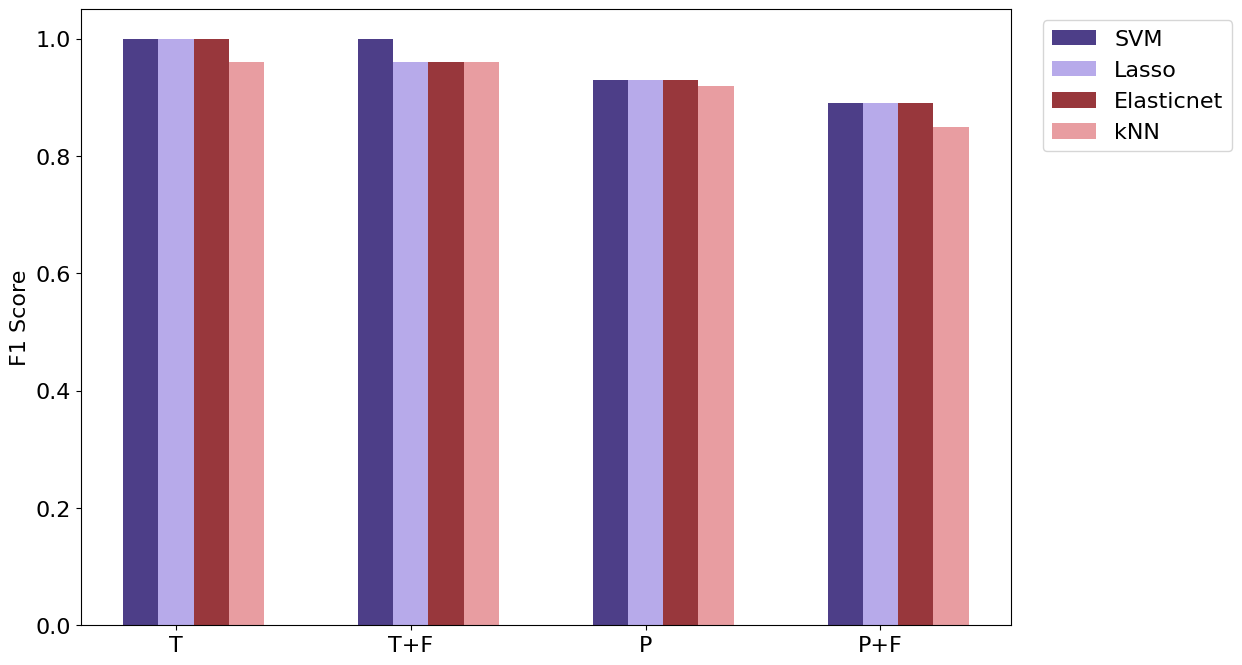

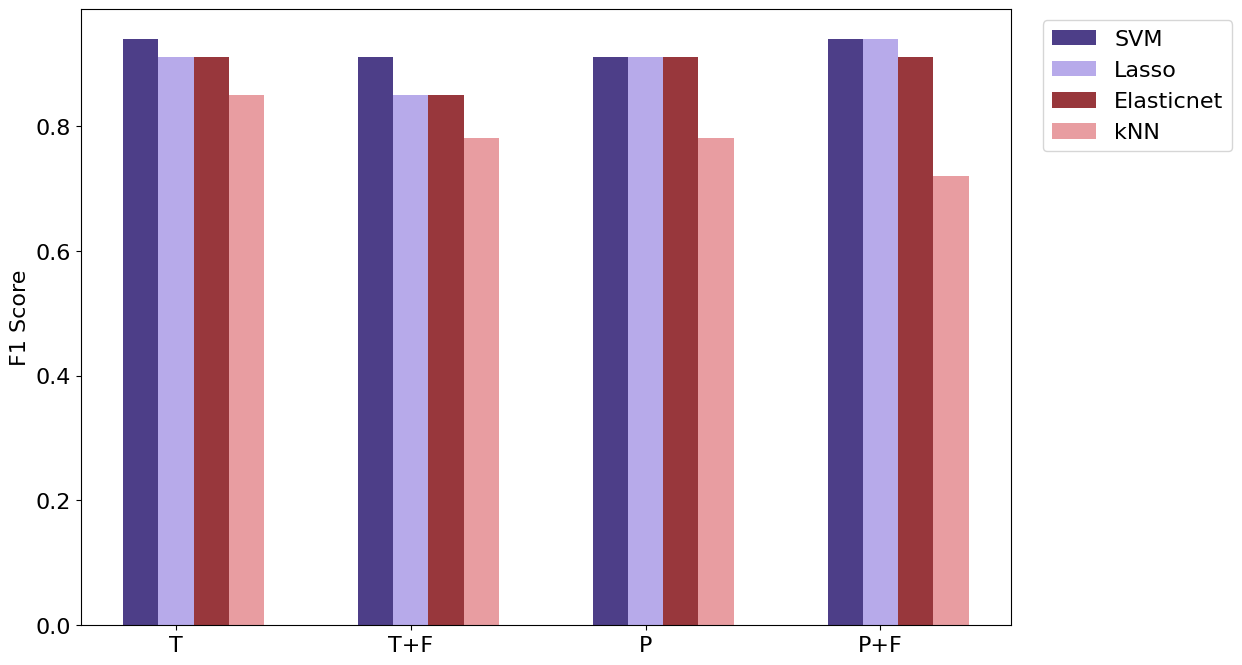

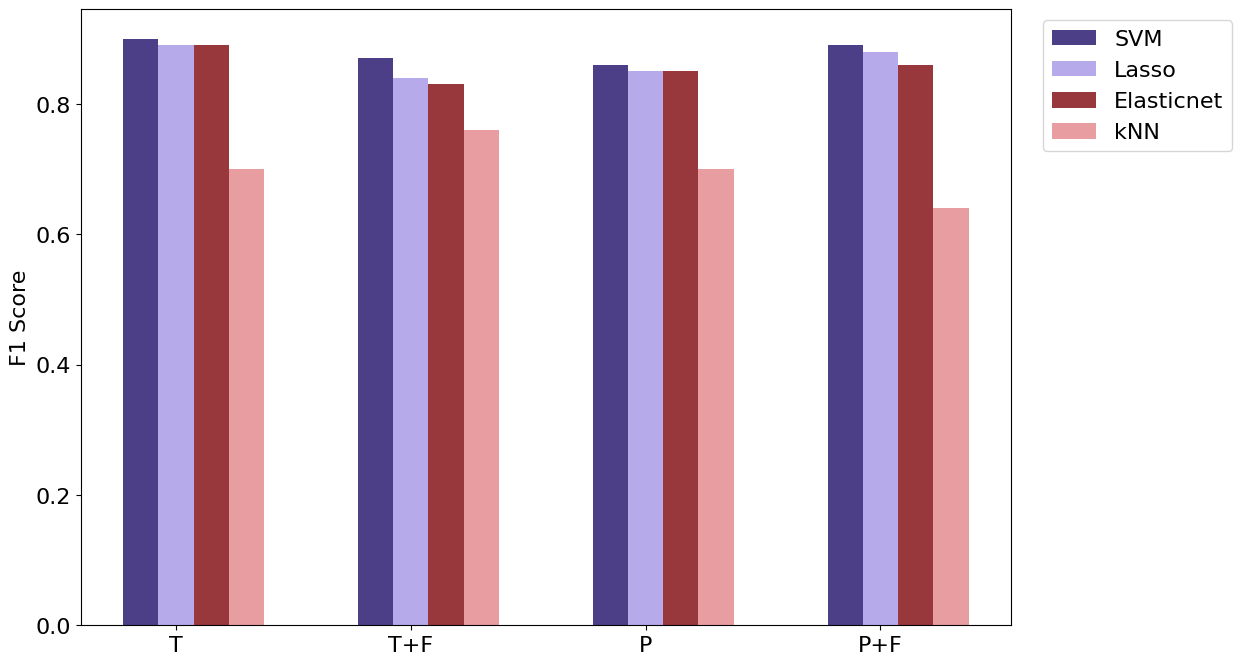

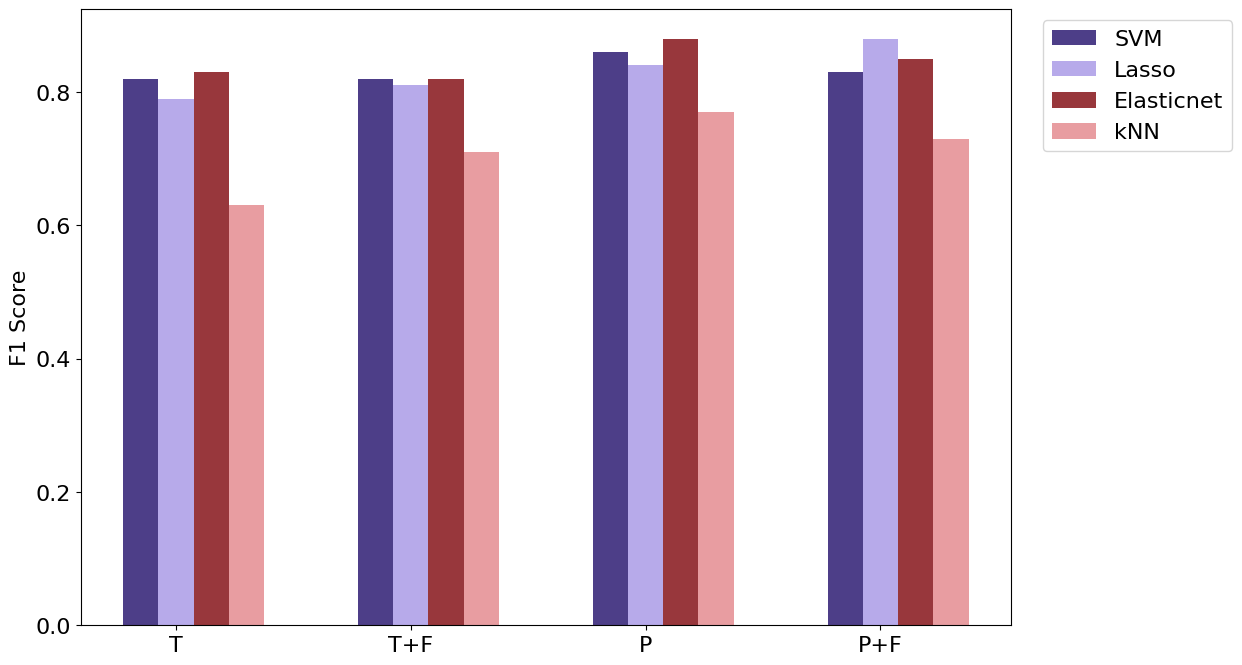

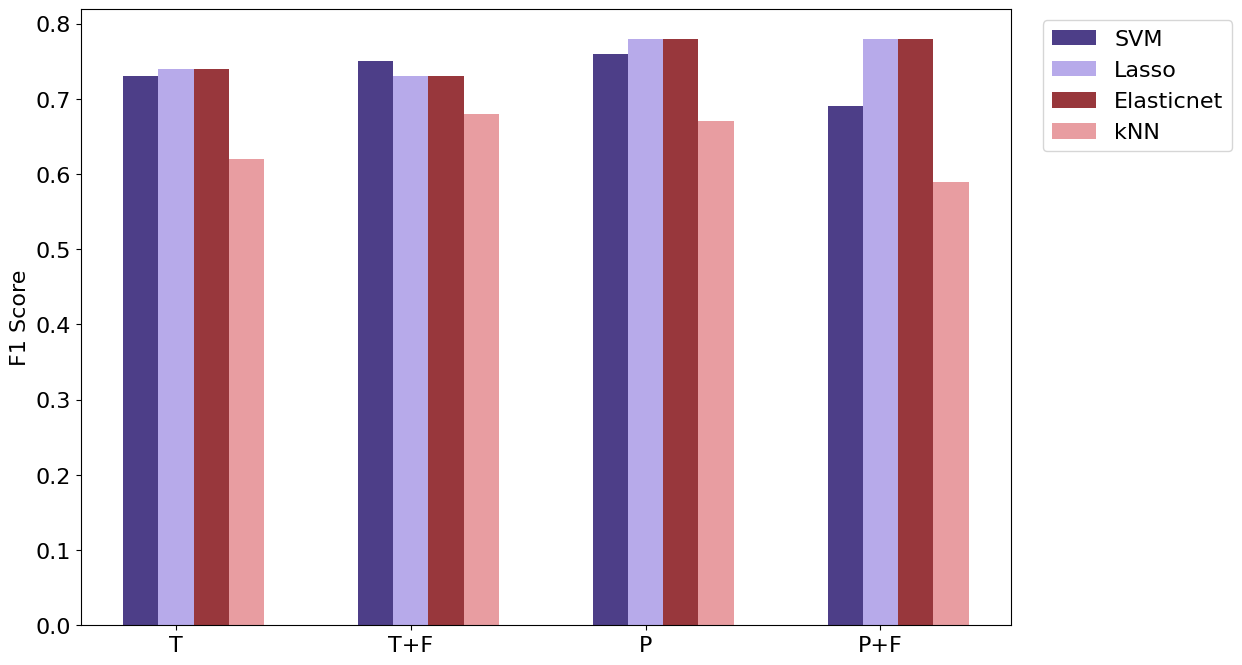

In [165]:
for split in ['10-90', '20-80', '30-70', '40-60', '50-50']:
    SVM = [stats_auc['SVM_'+i][split] for i in ['T', 'T_F', 'P', 'P_F']]
    Lasso = [stats_auc['Lasso_'+i][split] for i in ['T', 'T_F', 'P', 'P_F']]
    Elasticnet = [stats_auc['Elasticnet_'+i][split] for i in ['T', 'T_F', 'P', 'P_F']]
    kNN = [stats_auc['kNN_'+i][split] for i in ['T', 'T_F', 'P', 'P_F']]

    barWidth = 0.15
    br1 = np.arange(len(SVM)) 
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2] 
    br4 = [x + barWidth for x in br3] 

    plt.figure(figsize=(12, 8))
    plt.bar(br1, SVM, color ='#4d3e88', width = barWidth, label ='SVM') 
    plt.bar(br2, Lasso, color ='#b7aaea', width = barWidth, label ='Lasso') 
    plt.bar(br3, Elasticnet, color ='#98373c', width = barWidth, label ='Elasticnet') 
    plt.bar(br4, kNN, color ='#e89da1', width = barWidth, label ='kNN') 

    plt.ylabel('F1 Score', fontsize = 16) 
    plt.xticks([r + barWidth for r in range(len(SVM))], ['T', 'T+F', 'P', 'P+F'], fontsize=16)
    plt.yticks(fontsize=16)

    plt.legend(fontsize=16, loc='upper right', bbox_to_anchor=(1.25, 1.0))
    plt.show() 

In [166]:
best_models = pd.DataFrame()
best_models.index = [
    '10-90', '20-80', '30-70', '40-60', '50-50'
]

best_models['T'] = [1.00, 0.91, 0.90, 0.82, 0.74]
best_models['T_F'] = [1.00, 0.91, 0.87, 0.82, 0.73]

best_models['P'] = [0.93, 0.91, 0.85, 0.88, 0.78]
best_models['P_F'] = [0.89, 0.91, 0.89, 0.85, 0.78]

best_models_annot = pd.DataFrame()
best_models_annot.index = [
    '10-90', '20-80', '30-70', '40-60', '50-50'
]

best_models_annot['T'] = ['SVM', 'Lasso', 'SVM', 'SVM', 'Lasso']
best_models_annot['T_F'] = ['SVM', 'SVM', 'SVM', 'SVM', 'Lasso']

best_models_annot['P'] = ['Elastic-Net', 'SVM','Lasso', 'Elastic-Net', 'Elastic-Net']
best_models_annot['P_F'] = ['SVM', 'Elastic-Net', 'SVM', 'Elastic-Net', 'Lasso']


best_models

T   T_F     P   P_F
10-90  1.00  1.00  0.93  0.89
20-80  0.91  0.91  0.91  0.91
30-70  0.90  0.87  0.85  0.89
40-60  0.82  0.82  0.88  0.85
50-50  0.74  0.73  0.78  0.78

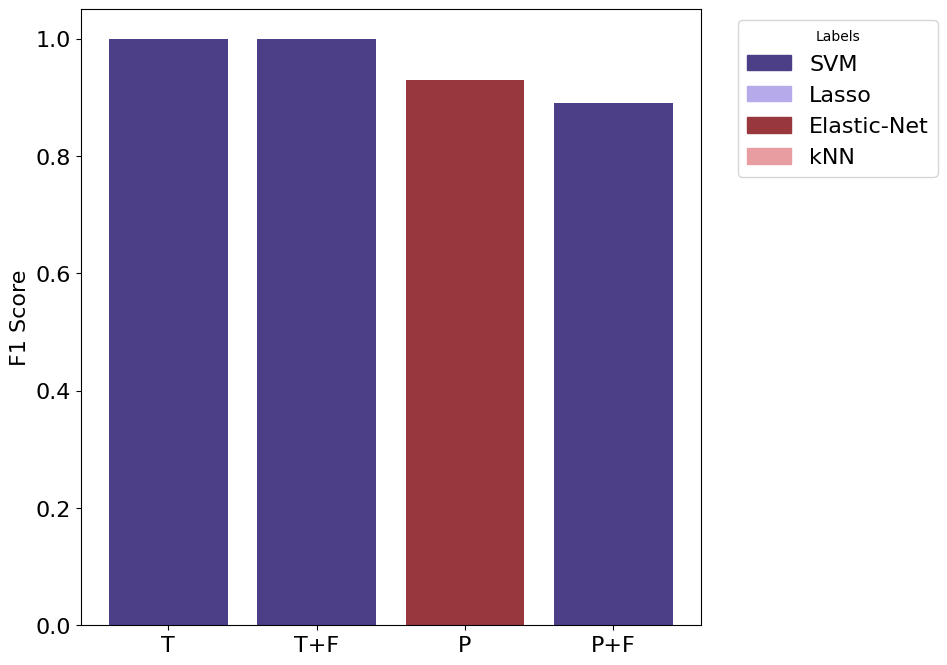

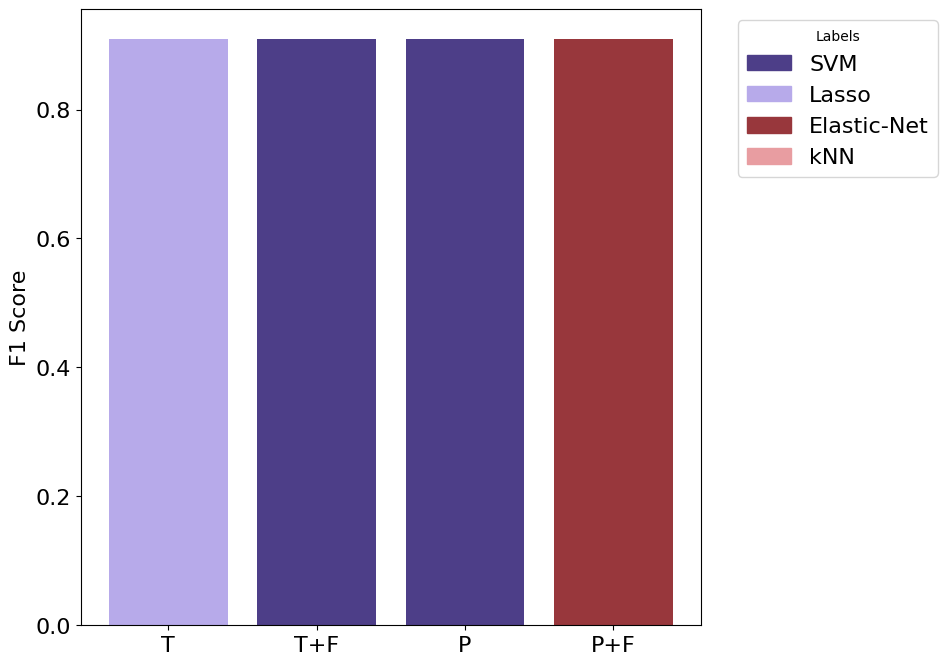

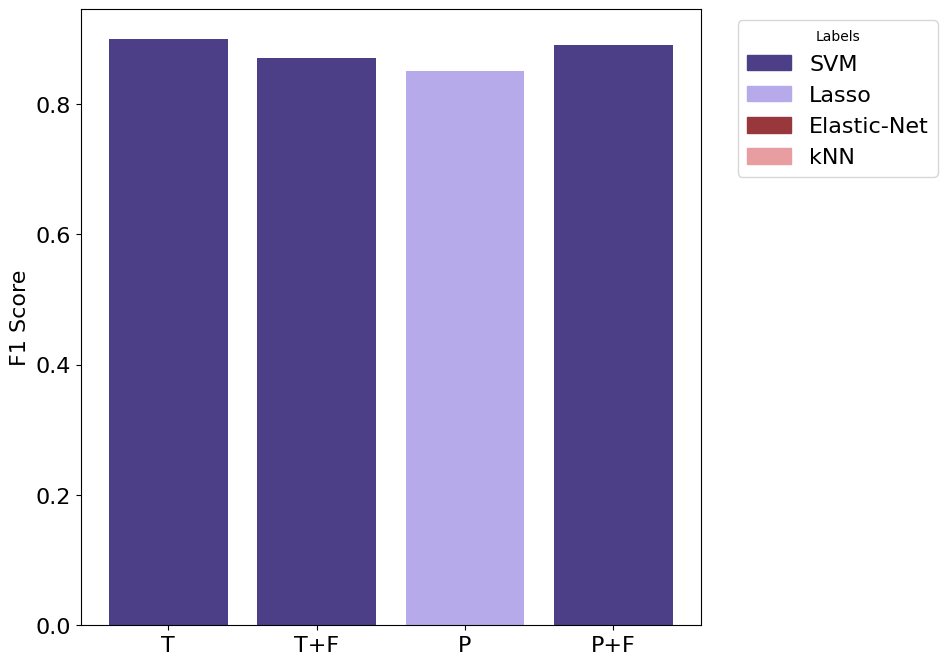

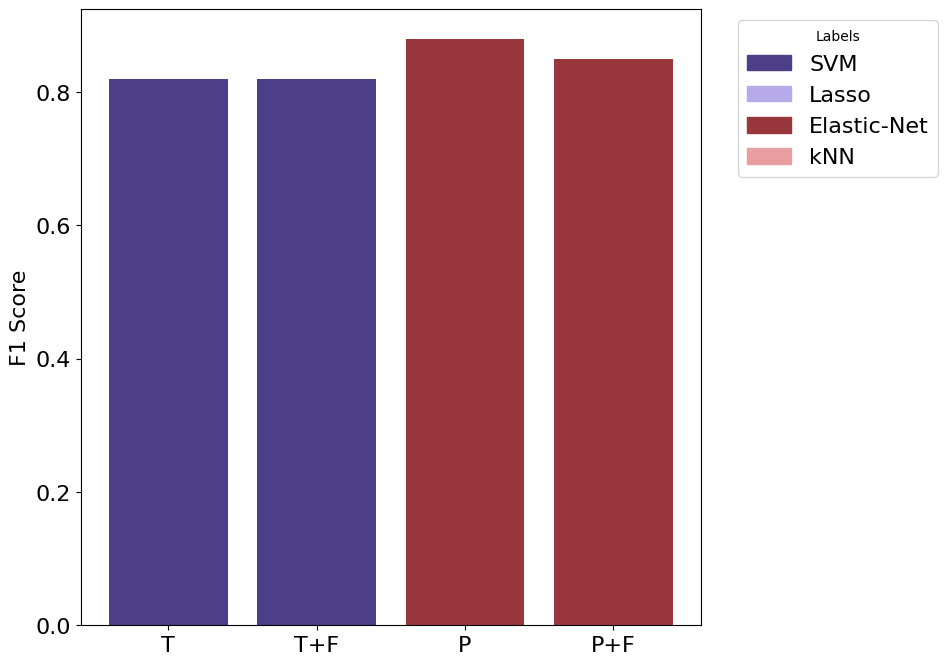

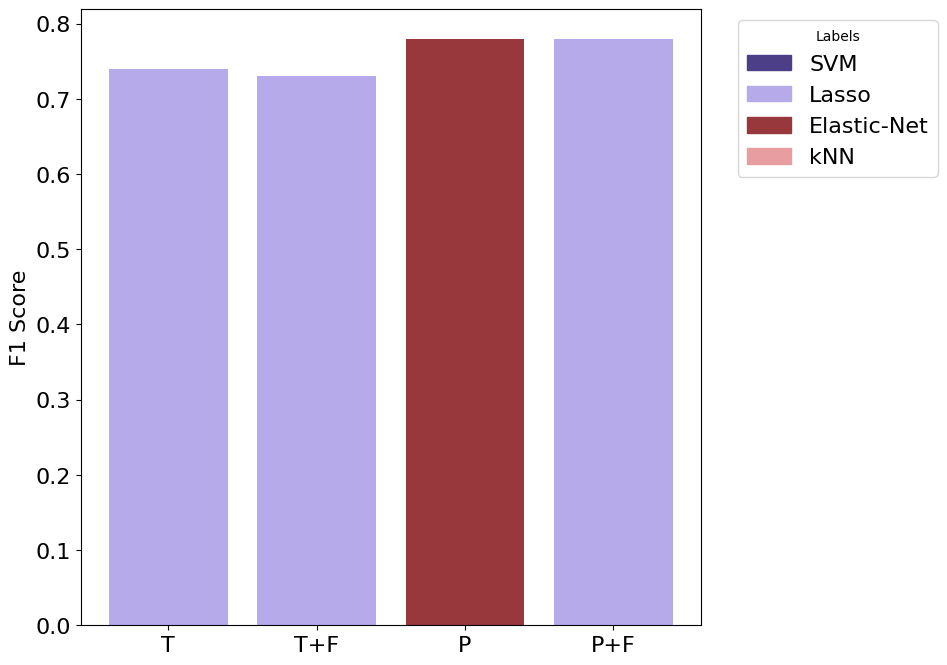

In [168]:
for split in ['10-90', '20-80', '30-70', '40-60', '50-50']:
    SVM = [best_models[i][split] for i in ['T', 'T_F', 'P', 'P_F']]

    bar_labels = [best_models[i][split] for i in ['T', 'T_F', 'P', 'P_F']]
    bar_colors = ['#4d3e88', '#b7aaea', '#98373c', '#e89da1']

    cols = [best_models_annot[i][split] for i in ['T', 'T_F', 'P', 'P_F']]
    col_colors = pd.Series(cols, index=[best_models_annot[i][split] for i in ['T', 'T_F', 'P', 'P_F']]).map({
        'SVM': '#4d3e88',
        'Lasso': '#b7aaea',
        'Elastic-Net': '#98373c',
        'kNN': '#e89da1',
    })


    legend_patches = [
        mpatches.Patch(color='#4d3e88', label='SVM'),
        mpatches.Patch(color='#b7aaea', label='Lasso'),
        mpatches.Patch(color='#98373c', label='Elastic-Net'),
        mpatches.Patch(color='#e89da1', label='kNN'),
    ]

    plt.figure(figsize=(8, 8))
    plt.bar(['T', 'T+F', 'P', 'P+F'], SVM, label=bar_labels, color=col_colors)

    plt.ylabel('F1 Score', fontsize = 16) 
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.legend(handles=legend_patches, title='Labels', loc='upper right',  bbox_to_anchor=(1.4, 1.0), fontsize=16)

Heatmaps of important features selected by the models

In [290]:
features_r = pd.read_csv("../feature selection/regressors_features.csv")
features_r.index = features_r['Unnamed: 0'].values
features_r.drop(columns=['Unnamed: 0'], inplace=True)

temp = features_r.loc['svm_t_f_glpk_50'][1818:]
svm_t_f = temp[temp > 0.0].sort_values(ascending=False)[:10].index

temp = features_r.loc['lasso_reg_t_f_glpk_50'][1818:]
lasso_reg_t_f = temp[temp > 0.0].sort_values(ascending=False)[:10].index

temp = features_r.loc['svm_p_f_glpk_50'][1818:]
svm_p_f = temp[temp > 0.0].sort_values(ascending=False)[:10].index

temp = features_r.loc['lasso_reg_p_f_glpk_50'][1818:]
lasso_reg_p_f = temp[temp > 0.0].sort_values(ascending=False)[:10].index

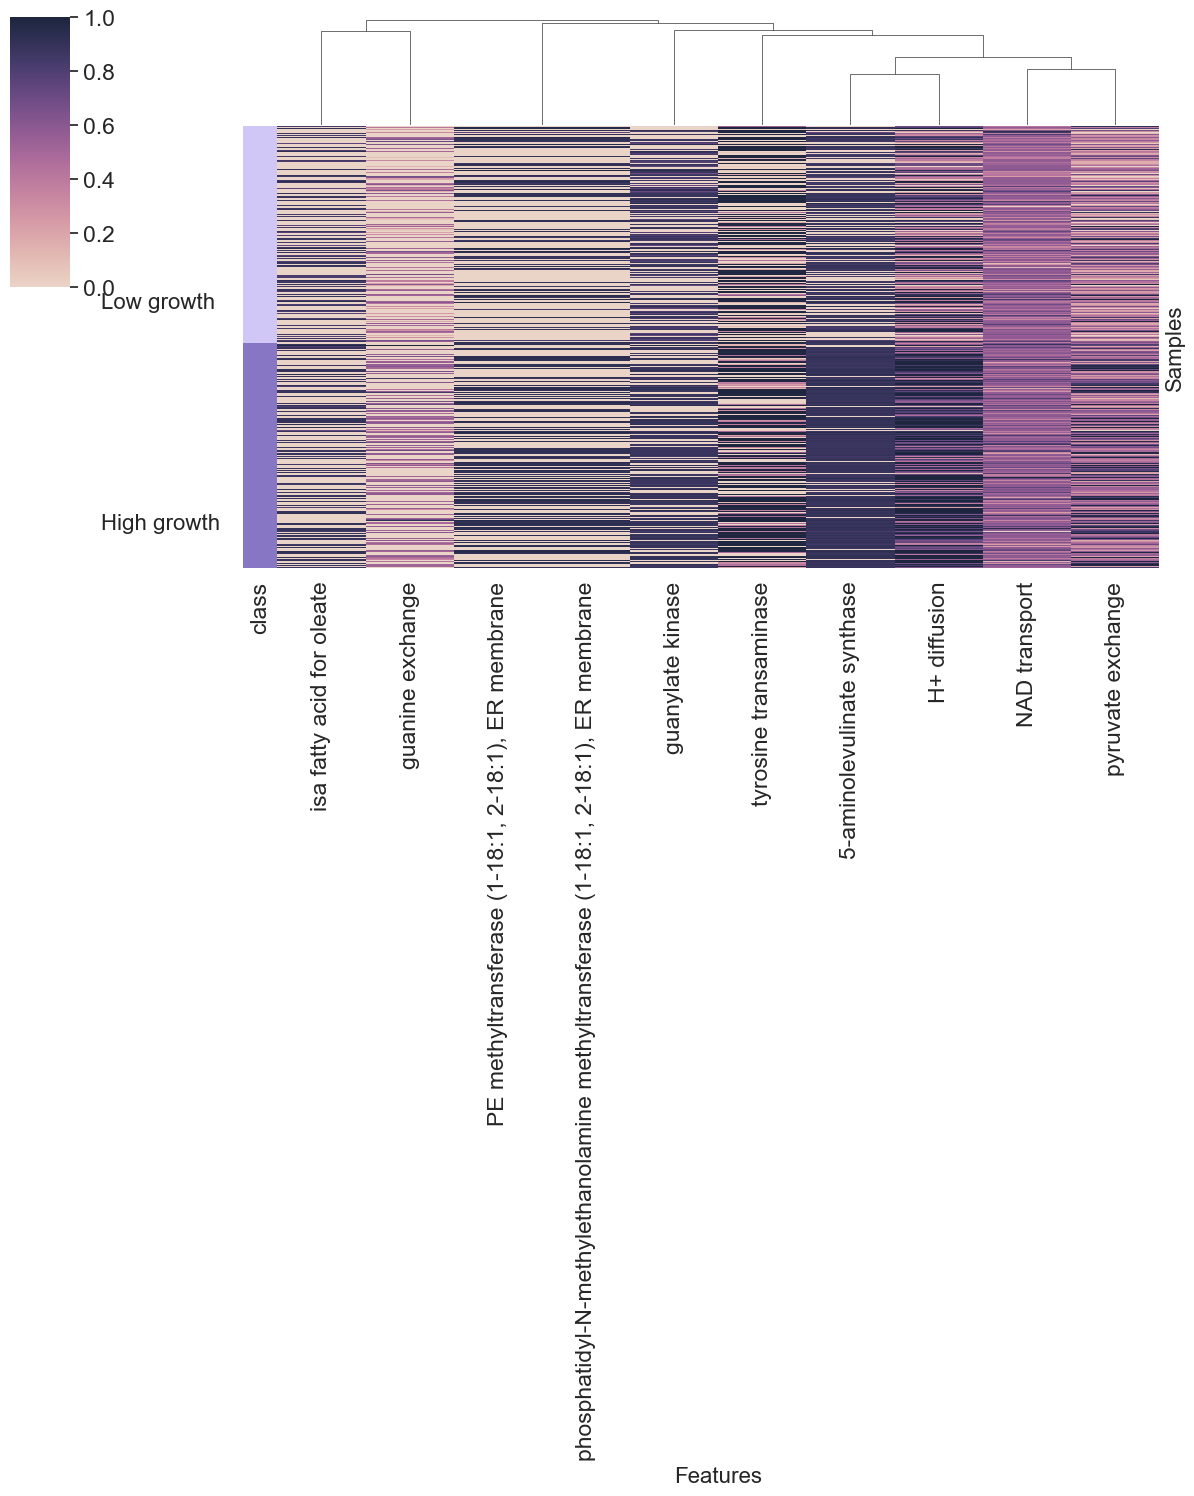

In [298]:
index = y['class'].sort_values().index
indices = [int(i) for i in lasso_reg_p_f]
rxns_names = [rxns[0][int(i)] for i in indices]
data = fluxes_p[indices]
cols = ['fluxomics' for i in range(data.shape[1])]
col_colors = pd.Series(cols, index=data.columns).map({
    'fluxomics': '#747cc8'
})
index = list(set(index).intersection(set(data.index)))
index = y.loc[index, 'class'].sort_values().index
g = sns.clustermap(data.loc[index, :], row_colors=y.loc[index, 'class'].map({0: '#d1c7f7', 2: '#8676c4'}),
                 figsize=(12, 15), cmap=sns.color_palette("ch:s=-.4,r=.6", as_cmap=True), 
                row_cluster=False,
                xticklabels=rxns_names,
    yticklabels=False)


legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='Low growth'),
    mpatches.Patch(color='#8676c4', label='High growth')
]
ax = g.ax_heatmap

# Add labels for the row colors (Low/High growth)
# Position depends on your plot size and how many samples you have
ax.text(-0.2, 0.6, 'Low growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')
ax.text(-0.2, 0.1, 'High growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')

# Remove default legend if present
if g.ax_col_dendrogram.legend_:
    g.ax_col_dendrogram.legend_.remove()

g.ax_heatmap.set_xlabel("Features", fontsize=16)
g.ax_heatmap.set_ylabel("Samples", fontsize=16)
sns.set(font_scale=1.5)

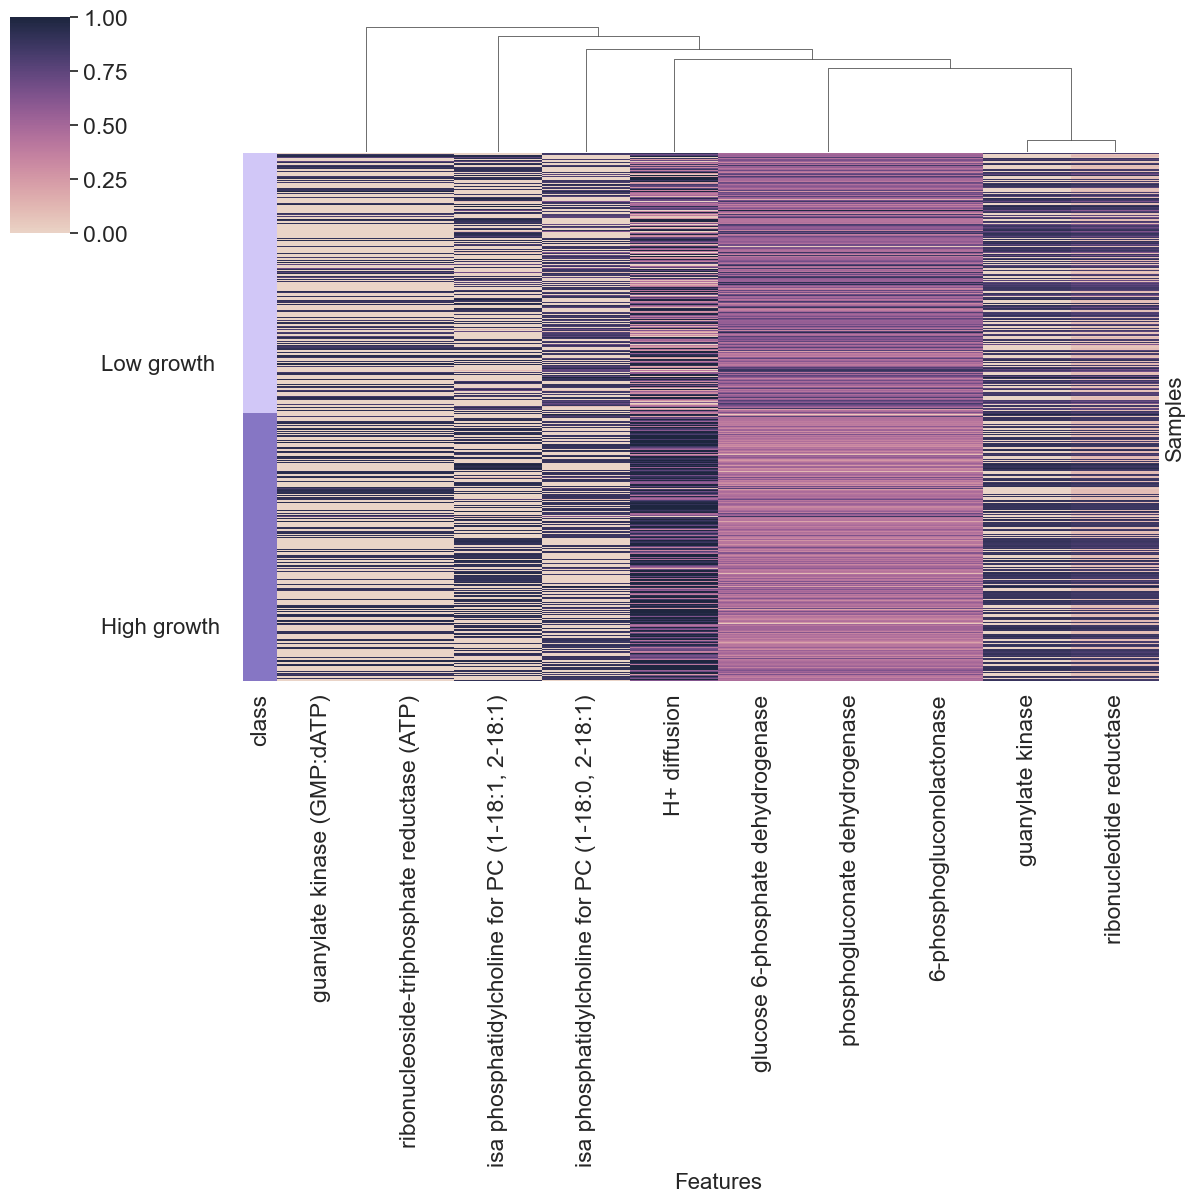

In [295]:
index = y['class'].sort_values().index
indices = [int(i) for i in svm_p_f]
rxns_names = [rxns[0][int(i)] for i in indices]
data = fluxes_p[indices]
cols = ['fluxomics' for i in range(data.shape[1])]
col_colors = pd.Series(cols, index=data.columns).map({
    'fluxomics': '#747cc8'
})
index = list(set(index).intersection(set(data.index)))
index = y.loc[index, 'class'].sort_values().index
g = sns.clustermap(data.loc[index, :], row_colors=y.loc[index, 'class'].map({0: '#d1c7f7', 2: '#8676c4'}),
                 figsize=(12, 12), cmap=sns.color_palette("ch:s=-.4,r=.6", as_cmap=True), 
                row_cluster=False,
                xticklabels=rxns_names,
    yticklabels=False)


legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='Low growth'),
    mpatches.Patch(color='#8676c4', label='High growth')
]
ax = g.ax_heatmap

# Add labels for the row colors (Low/High growth)
# Position depends on your plot size and how many samples you have
ax.text(-0.2, 0.6, 'Low growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')
ax.text(-0.2, 0.1, 'High growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')

# Remove default legend if present
if g.ax_col_dendrogram.legend_:
    g.ax_col_dendrogram.legend_.remove()

g.ax_heatmap.set_xlabel("Features", fontsize=16)
g.ax_heatmap.set_ylabel("Samples", fontsize=16)
sns.set(font_scale=1.5)

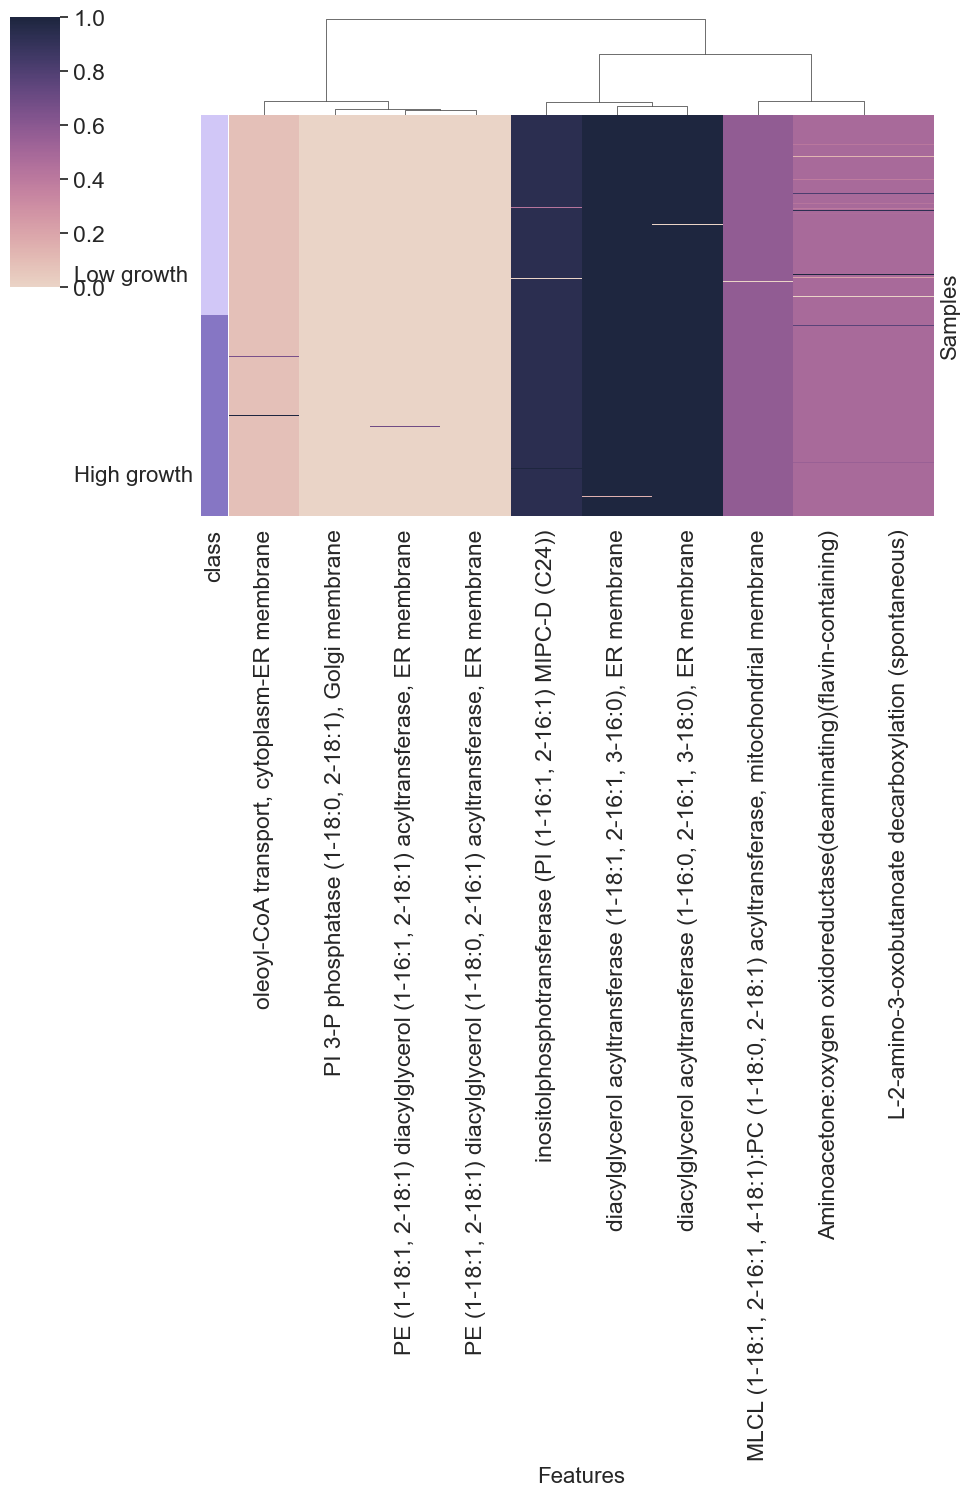

In [299]:
index = gr_measured_ML['class'].sort_values().index
indices = [int(i) for i in lasso_reg_t_f]
rxns_names = [rxns[0][int(i)] for i in indices]
data = fluxes_t[indices]
cols = ['fluxomics' for i in range(data.shape[1])]
col_colors = pd.Series(cols, index=data.columns).map({
    'fluxomics': '#747cc8'
})
g = sns.clustermap(data.loc[index, :], row_colors=gr_measured_ML.loc[index, 'class'].map({0: '#d1c7f7', 2: '#8676c4'}),
                 figsize=(10, 15), cmap=sns.color_palette("ch:s=-.4,r=.6", as_cmap=True), 
                row_cluster=False,
                xticklabels=rxns_names,
    yticklabels=False)


legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='Low growth'),
    mpatches.Patch(color='#8676c4', label='High growth')
]
ax = g.ax_heatmap

# Add labels for the row colors (Low/High growth)
# Position depends on your plot size and how many samples you have
ax.text(-0.22, 0.6, 'Low growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')
ax.text(-0.22, 0.1, 'High growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')

# Remove default legend if present
if g.ax_col_dendrogram.legend_:
    g.ax_col_dendrogram.legend_.remove()

g.ax_heatmap.set_xlabel("Features", fontsize=16)
g.ax_heatmap.set_ylabel("Samples", fontsize=16)
sns.set(font_scale=1.5)

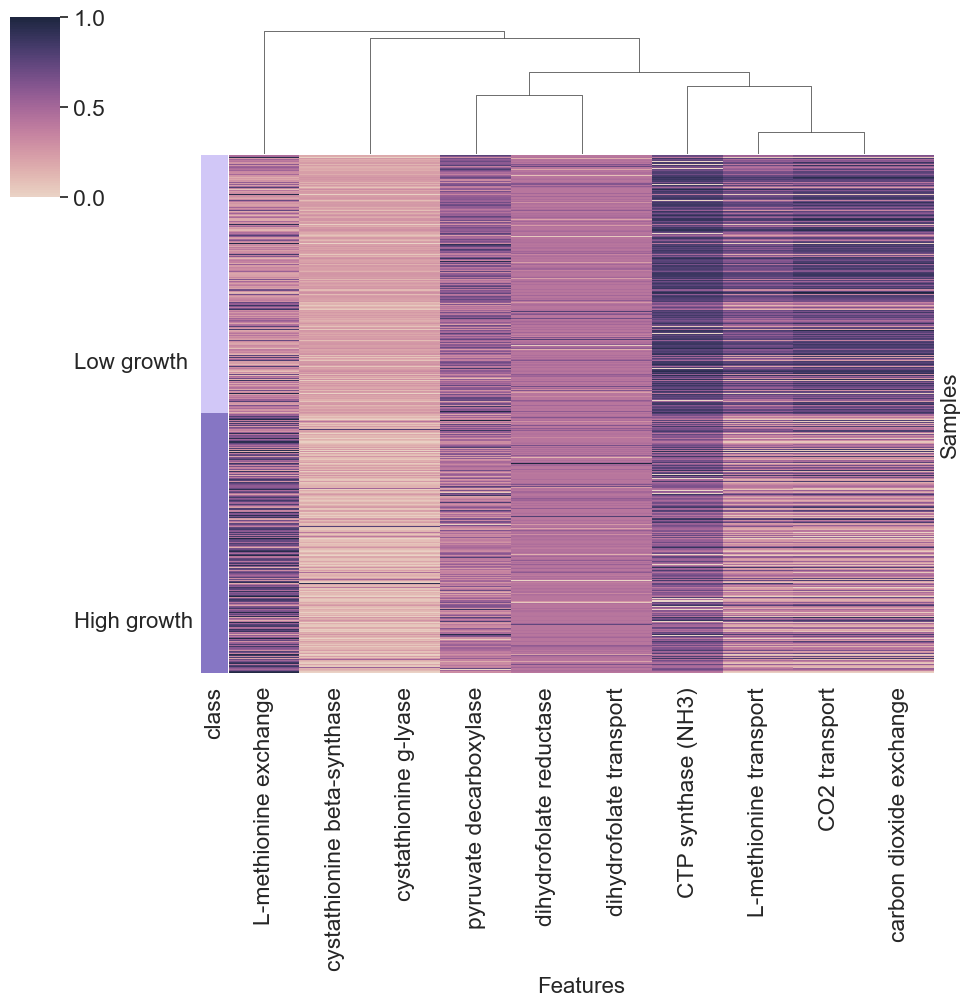

In [287]:
index = gr_measured_ML['class'].sort_values().index
indices = [int(i) for i in svm_t_f]
rxns_names = [rxns[0][int(i)] for i in indices]
data = fluxes_t[indices]
cols = ['fluxomics' for i in range(data.shape[1])]
col_colors = pd.Series(cols, index=data.columns).map({
    'fluxomics': '#747cc8'
})
g = sns.clustermap(data.loc[index, :], row_colors=gr_measured_ML.loc[index, 'class'].map({0: '#d1c7f7', 2: '#8676c4'}),
                 figsize=(10, 10), cmap=sns.color_palette("ch:s=-.4,r=.6", as_cmap=True), 
                row_cluster=False,
                xticklabels=rxns_names,
    yticklabels=False)


legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='Low growth'),
    mpatches.Patch(color='#8676c4', label='High growth')
]
ax = g.ax_heatmap

# Add labels for the row colors (Low/High growth)
# Position depends on your plot size and how many samples you have
ax.text(-0.22, 0.6, 'Low growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')
ax.text(-0.22, 0.1, 'High growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')

# Remove default legend if present
if g.ax_col_dendrogram.legend_:
    g.ax_col_dendrogram.legend_.remove()

g.ax_heatmap.set_xlabel("Features", fontsize=16)
g.ax_heatmap.set_ylabel("Samples", fontsize=16)
sns.set(font_scale=1.5)

Heatmap of feratures selected from pathway analysis

In [174]:
svm_t_f = pd.read_csv("../feature selection/pathway analysis/SVM_T_F_pathways.csv")
svm_p_f = pd.read_csv("../feature selection/pathway analysis/SVM_P_F_pathways.csv")
knn_t_f = pd.read_csv("../feature selection/pathway analysis/KNN_T_F_pathways.csv")
knn_p_f = pd.read_csv("../feature selection/pathway analysis/KNN_P_F_pathways.csv")
elasticnet_p_f =pd.read_csv("../feature selection/pathway analysis/ElasticNet_P_F_pathways.csv")
lasso_p_f = pd.read_csv("../feature selection/pathway analysis/Lasso_P_F_pathways.csv")

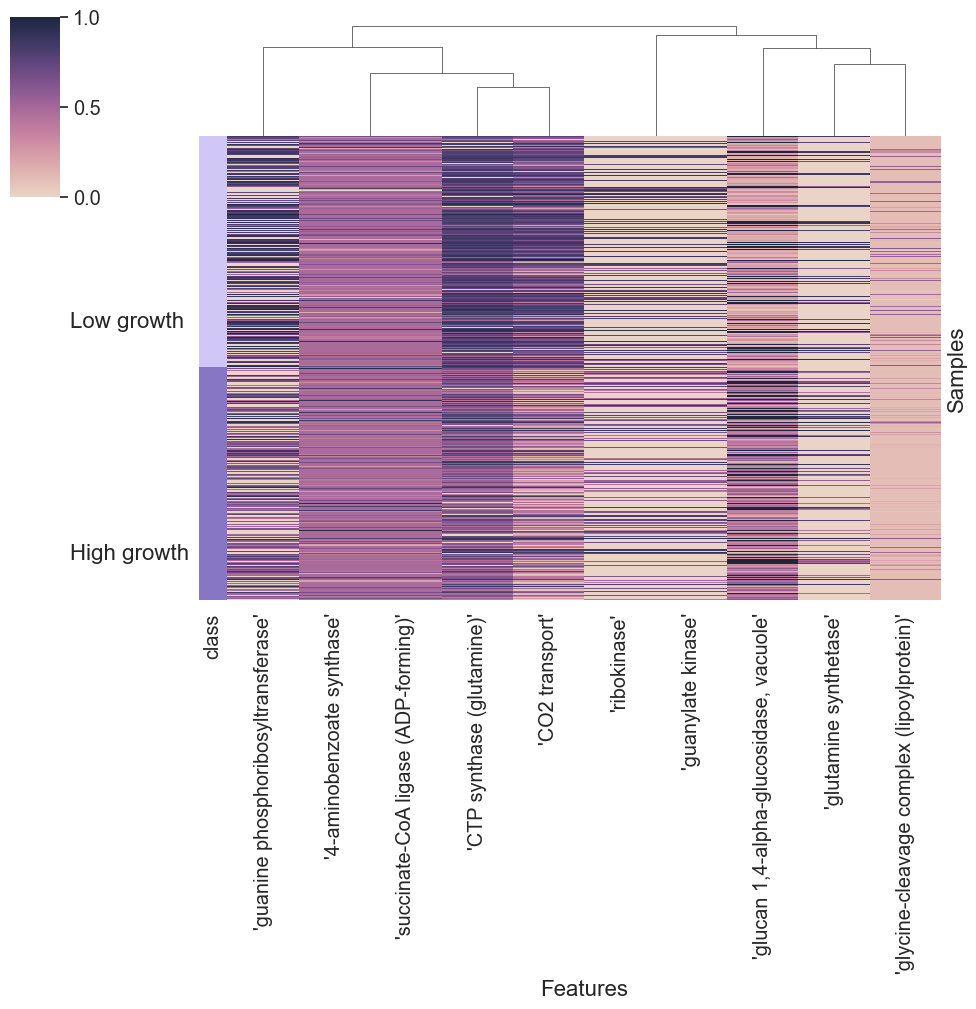

In [238]:
index = gr_measured_ML['class'].sort_values().index
indices = svm_t_f.sort_values('svm_t_f_glpk_30', ascending=False)['rxn_id'][:10]
rxns_names = svm_t_f.sort_values('svm_t_f_glpk_30', ascending=False)['rxn_name'][:10]
data = fluxes_t[indices]
cols = ['fluxomics' for i in range(data.shape[1])]
col_colors = pd.Series(cols, index=data.columns).map({
    'fluxomics': '#747cc8'
})
g = sns.clustermap(data.loc[index, :], row_colors=gr_measured_ML.loc[index, 'class'].map({0: '#d1c7f7', 2: '#8676c4'}),
                 figsize=(10, 10), cmap=sns.color_palette("ch:s=-.4,r=.6", as_cmap=True), 
                row_cluster=False,
                xticklabels=rxns_names,
    yticklabels=False)


legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='Low growth'),
    mpatches.Patch(color='#8676c4', label='High growth')
]
ax = g.ax_heatmap

# Add labels for the row colors (Low/High growth)
# Position depends on your plot size and how many samples you have
ax.text(-0.22, 0.6, 'Low growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')
ax.text(-0.22, 0.1, 'High growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')

# Remove default legend if present
if g.ax_col_dendrogram.legend_:
    g.ax_col_dendrogram.legend_.remove()

g.ax_heatmap.set_xlabel("Features", fontsize=16)
g.ax_heatmap.set_ylabel("Samples", fontsize=16)
sns.set(font_scale=1.5)

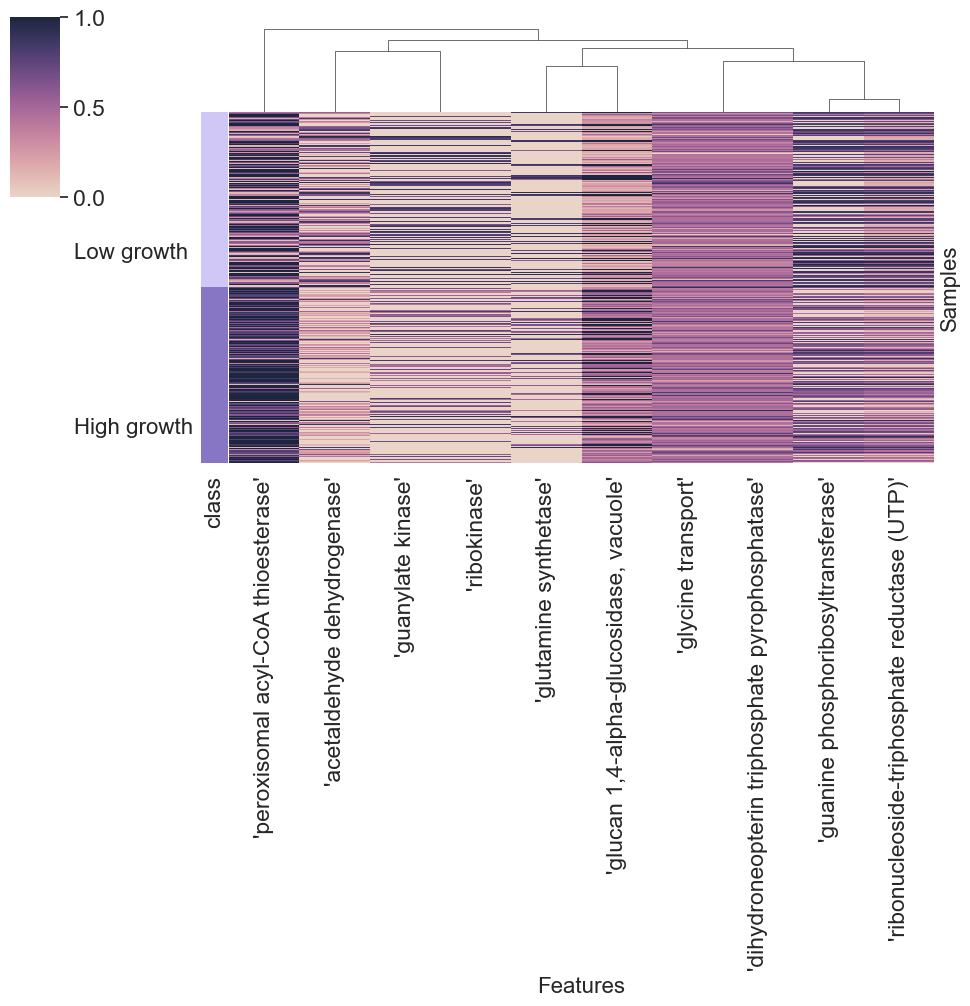

In [255]:
index = gr_measured_ML['class'].sort_values().index
indices = knn_t_f.sort_values('knn_t_f_glpk_30', ascending=False)['rxn_id'][:10]
rxns_names = knn_t_f.sort_values('knn_t_f_glpk_30', ascending=False)['rxn_name'][:10]
data = fluxes_t[indices]
cols = ['fluxomics' for i in range(data.shape[1])]
col_colors = pd.Series(cols, index=data.columns).map({
    'fluxomics': '#747cc8'
})
g = sns.clustermap(data.loc[index, :], row_colors=gr_measured_ML.loc[index, 'class'].map({0: '#d1c7f7', 2: '#8676c4'}),
                 figsize=(10, 10), cmap=sns.color_palette("ch:s=-.4,r=.6", as_cmap=True), 
                row_cluster=False,
                xticklabels=rxns_names,
    yticklabels=False)


legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='Low growth'),
    mpatches.Patch(color='#8676c4', label='High growth')
]
ax = g.ax_heatmap

# Add labels for the row colors (Low/High growth)
# Position depends on your plot size and how many samples you have
ax.text(-0.22, 0.6, 'Low growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')
ax.text(-0.22, 0.1, 'High growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')

# Remove default legend if present
if g.ax_col_dendrogram.legend_:
    g.ax_col_dendrogram.legend_.remove()

g.ax_heatmap.set_xlabel("Features", fontsize=16)
g.ax_heatmap.set_ylabel("Samples", fontsize=16)
sns.set(font_scale=1.5)

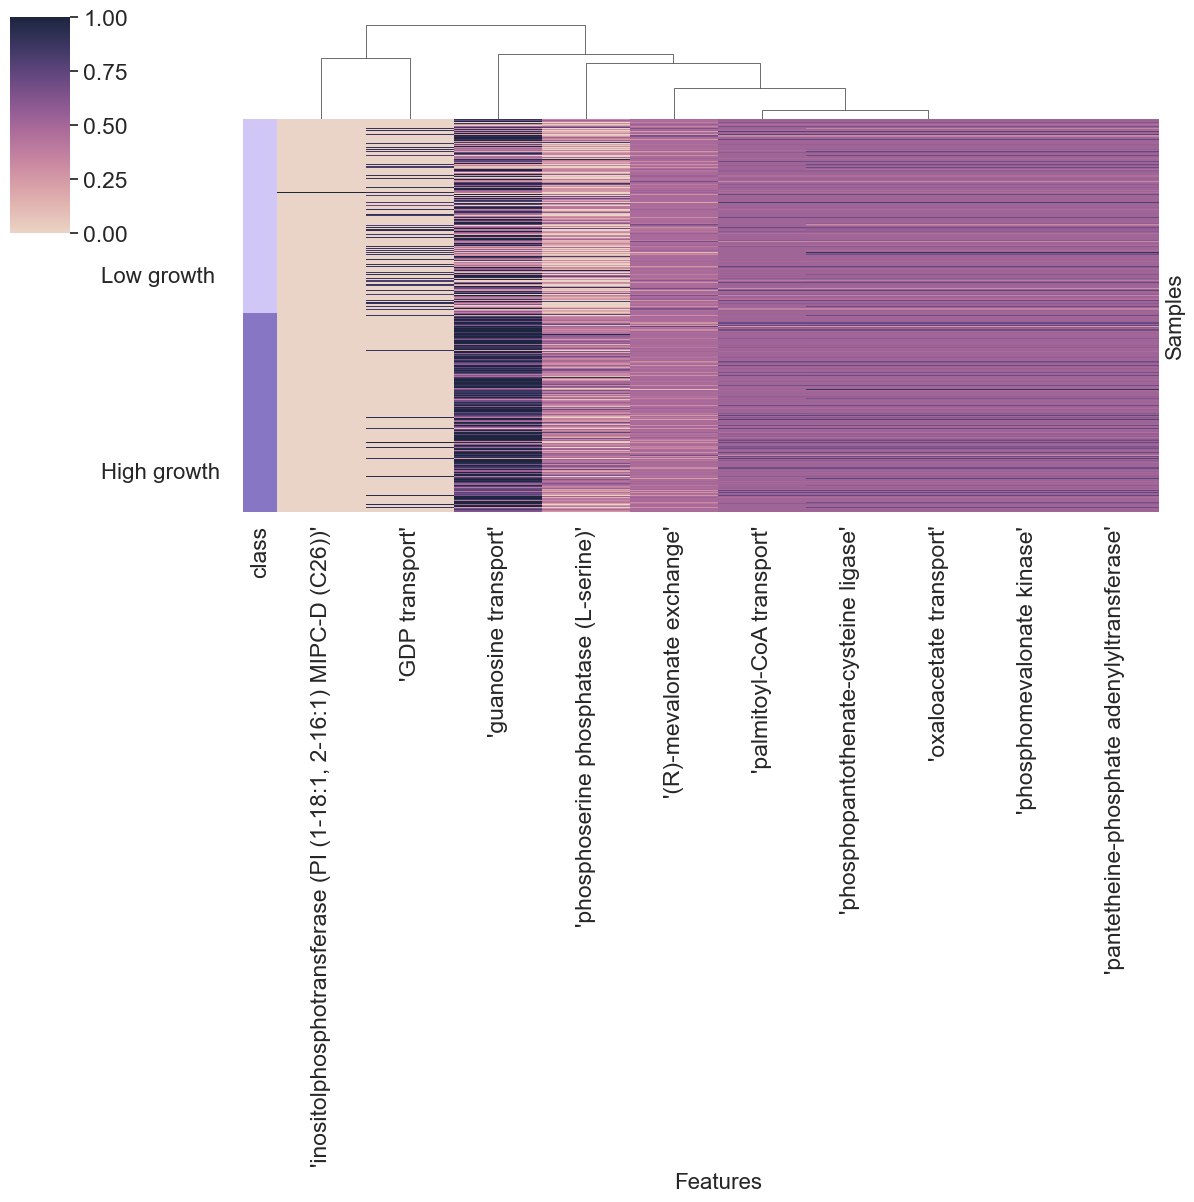

In [254]:
index = y['class'].sort_values().index
indices = svm_p_f.sort_values('svm_p_f_glpk_30', ascending=False)['rxn_id'][:10]
rxns_names = svm_p_f.sort_values('svm_p_f_glpk_30', ascending=False)['rxn_name'][:10]
data = fluxes_p[indices]
cols = ['fluxomics' for i in range(data.shape[1])]
col_colors = pd.Series(cols, index=data.columns).map({
    'fluxomics': '#747cc8'
})
index = list(set(index).intersection(set(data.index)))
index = y.loc[index, 'class'].sort_values().index
g = sns.clustermap(data.loc[index, :], row_colors=y.loc[index, 'class'].map({0: '#d1c7f7', 2: '#8676c4'}),
                 figsize=(12, 12), cmap=sns.color_palette("ch:s=-.4,r=.6", as_cmap=True), 
                row_cluster=False,
                xticklabels=rxns_names,
    yticklabels=False)


legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='Low growth'),
    mpatches.Patch(color='#8676c4', label='High growth')
]
ax = g.ax_heatmap

# Add labels for the row colors (Low/High growth)
# Position depends on your plot size and how many samples you have
ax.text(-0.2, 0.6, 'Low growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')
ax.text(-0.2, 0.1, 'High growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')

# Remove default legend if present
if g.ax_col_dendrogram.legend_:
    g.ax_col_dendrogram.legend_.remove()

g.ax_heatmap.set_xlabel("Features", fontsize=16)
g.ax_heatmap.set_ylabel("Samples", fontsize=16)
sns.set(font_scale=1.5)

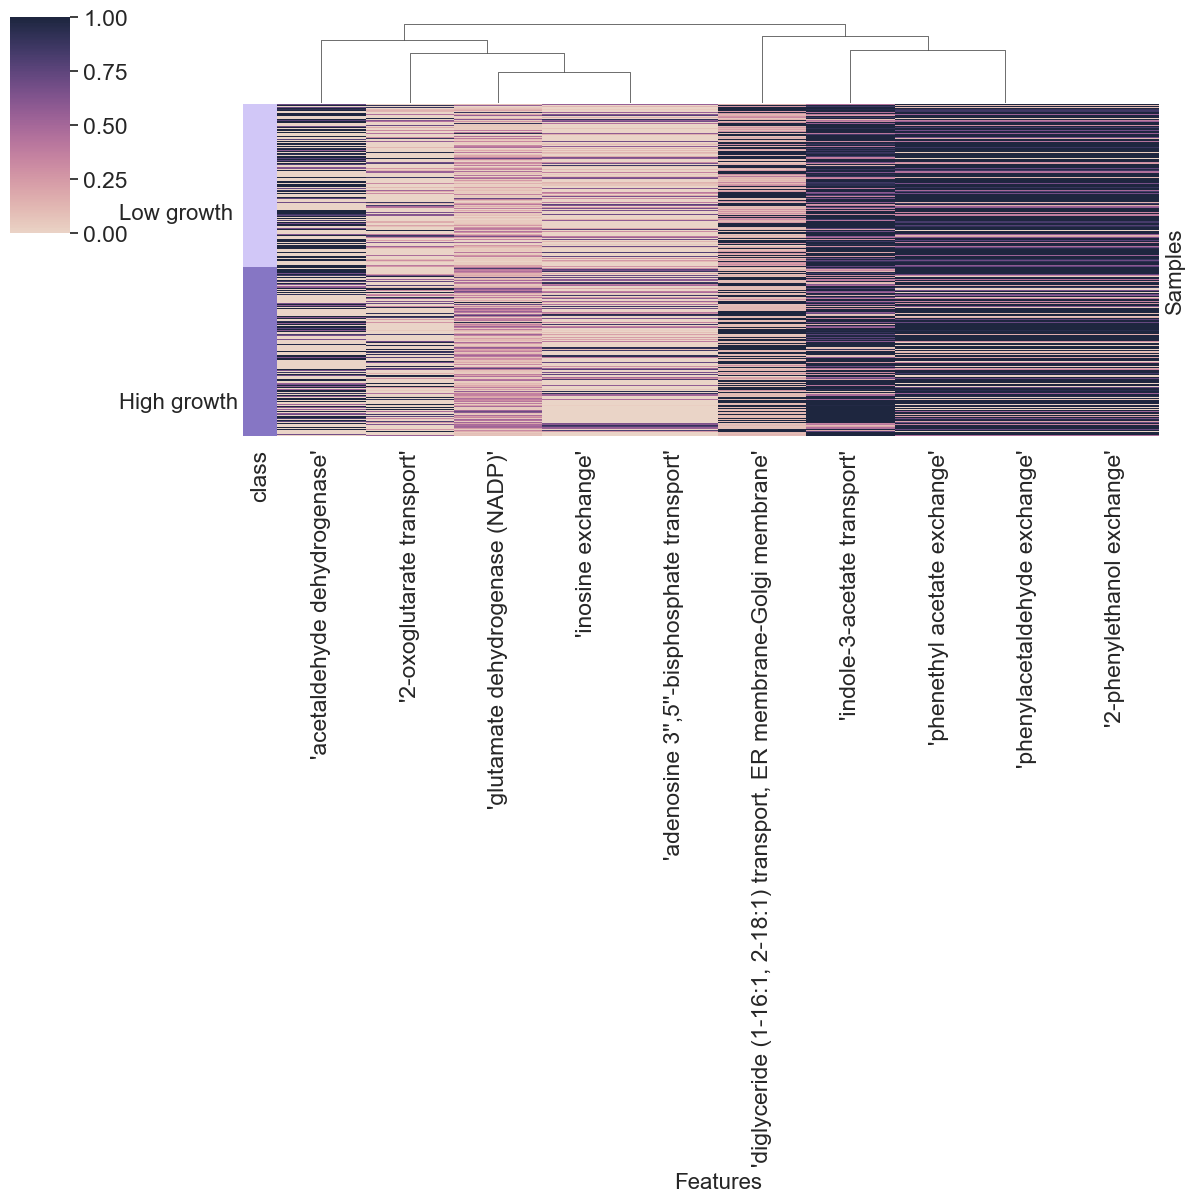

In [262]:
index = y['class'].sort_values().index
indices = knn_p_f.sort_values('knn_p_f_glpk_30', ascending=False)['rxn_id'][:10]
rxns_names = knn_p_f.sort_values('knn_p_f_glpk_30', ascending=False)['rxn_name'][:10]
data = fluxes_p[indices]
cols = ['fluxomics' for i in range(data.shape[1])]
col_colors = pd.Series(cols, index=data.columns).map({
    'fluxomics': '#747cc8'
})
index = list(set(index).intersection(set(data.index)))
index = y.loc[index, 'class'].sort_values().index
g = sns.clustermap(data.loc[index, :], row_colors=y.loc[index, 'class'].map({0: '#d1c7f7', 2: '#8676c4'}),
                 figsize=(12, 12), cmap=sns.color_palette("ch:s=-.4,r=.6", as_cmap=True), 
                row_cluster=False,
                xticklabels=rxns_names,
    yticklabels=False)


legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='Low growth'),
    mpatches.Patch(color='#8676c4', label='High growth')
]
ax = g.ax_heatmap

# Add labels for the row colors (Low/High growth)
# Position depends on your plot size and how many samples you have
ax.text(-0.18, 0.67, 'Low growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')
ax.text(-0.18, 0.1, 'High growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')

# Remove default legend if present
if g.ax_col_dendrogram.legend_:
    g.ax_col_dendrogram.legend_.remove()

g.ax_heatmap.set_xlabel("Features", fontsize=16)
g.ax_heatmap.set_ylabel("Samples", fontsize=16)
sns.set(font_scale=1.5)

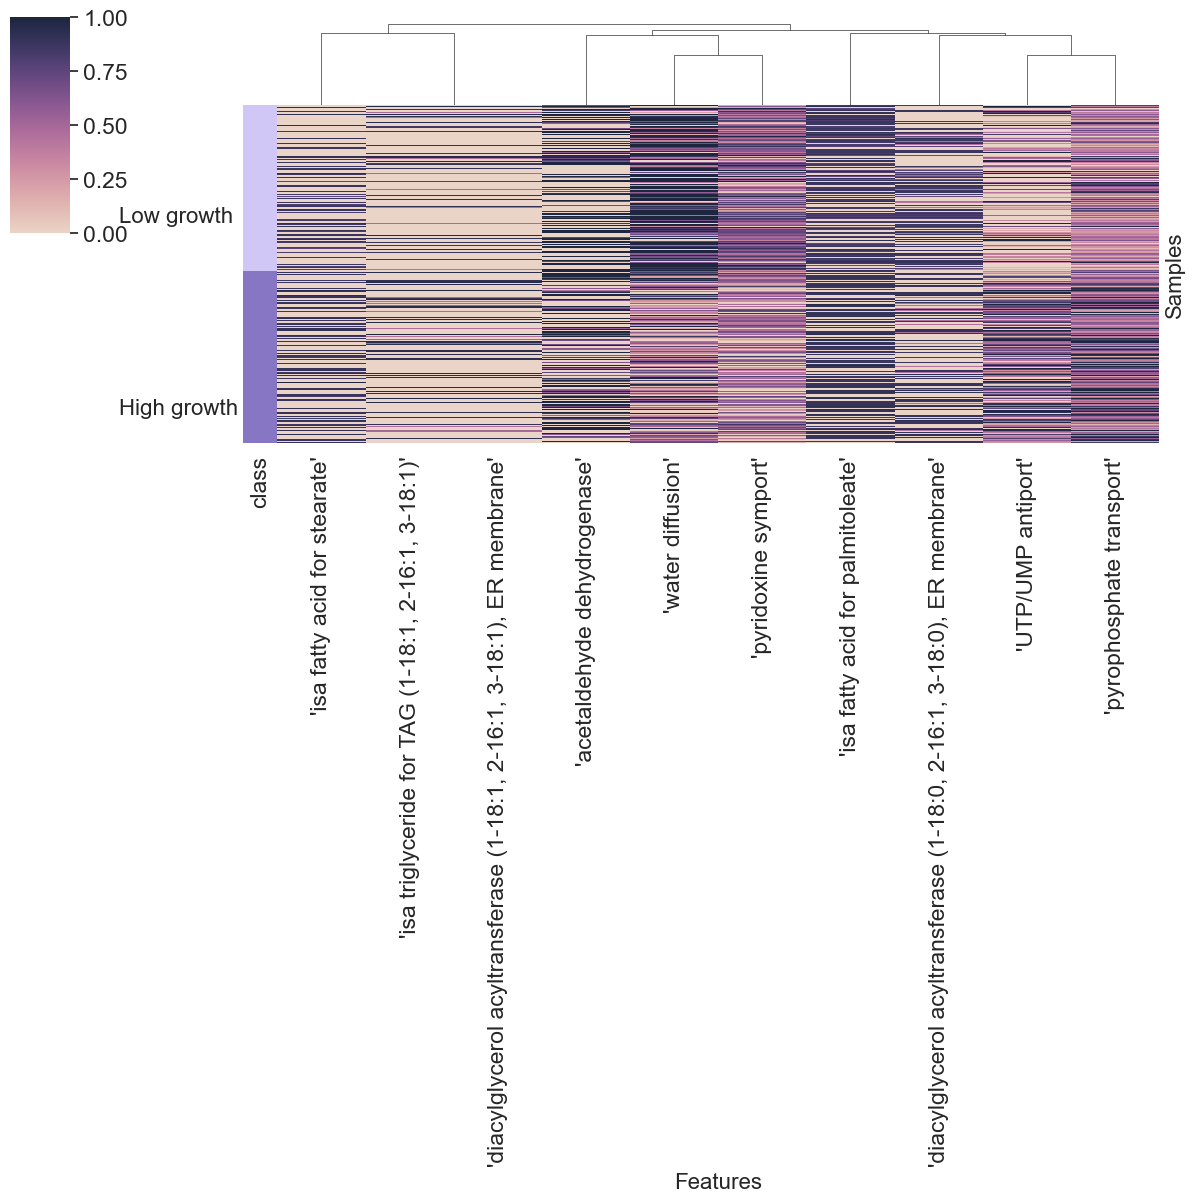

In [266]:
index = y['class'].sort_values().index
indices = elasticnet_p_f.sort_values('elasticnet_log_p_f_glpk_30', ascending=False)['rxn_id'][:10]
rxns_names = elasticnet_p_f.sort_values('elasticnet_log_p_f_glpk_30', ascending=False)['rxn_name'][:10]
data = fluxes_p[indices]
cols = ['fluxomics' for i in range(data.shape[1])]
col_colors = pd.Series(cols, index=data.columns).map({
    'fluxomics': '#747cc8'
})
index = list(set(index).intersection(set(data.index)))
index = y.loc[index, 'class'].sort_values().index
g = sns.clustermap(data.loc[index, :], row_colors=y.loc[index, 'class'].map({0: '#d1c7f7', 2: '#8676c4'}),
                 figsize=(12, 12), cmap=sns.color_palette("ch:s=-.4,r=.6", as_cmap=True), 
                row_cluster=False,
                xticklabels=rxns_names,
    yticklabels=False)


legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='Low growth'),
    mpatches.Patch(color='#8676c4', label='High growth')
]
ax = g.ax_heatmap

# Add labels for the row colors (Low/High growth)
# Position depends on your plot size and how many samples you have
ax.text(-0.18, 0.67, 'Low growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')
ax.text(-0.18, 0.1, 'High growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')

# Remove default legend if present
if g.ax_col_dendrogram.legend_:
    g.ax_col_dendrogram.legend_.remove()

g.ax_heatmap.set_xlabel("Features", fontsize=16)
g.ax_heatmap.set_ylabel("Samples", fontsize=16)
sns.set(font_scale=1.5)

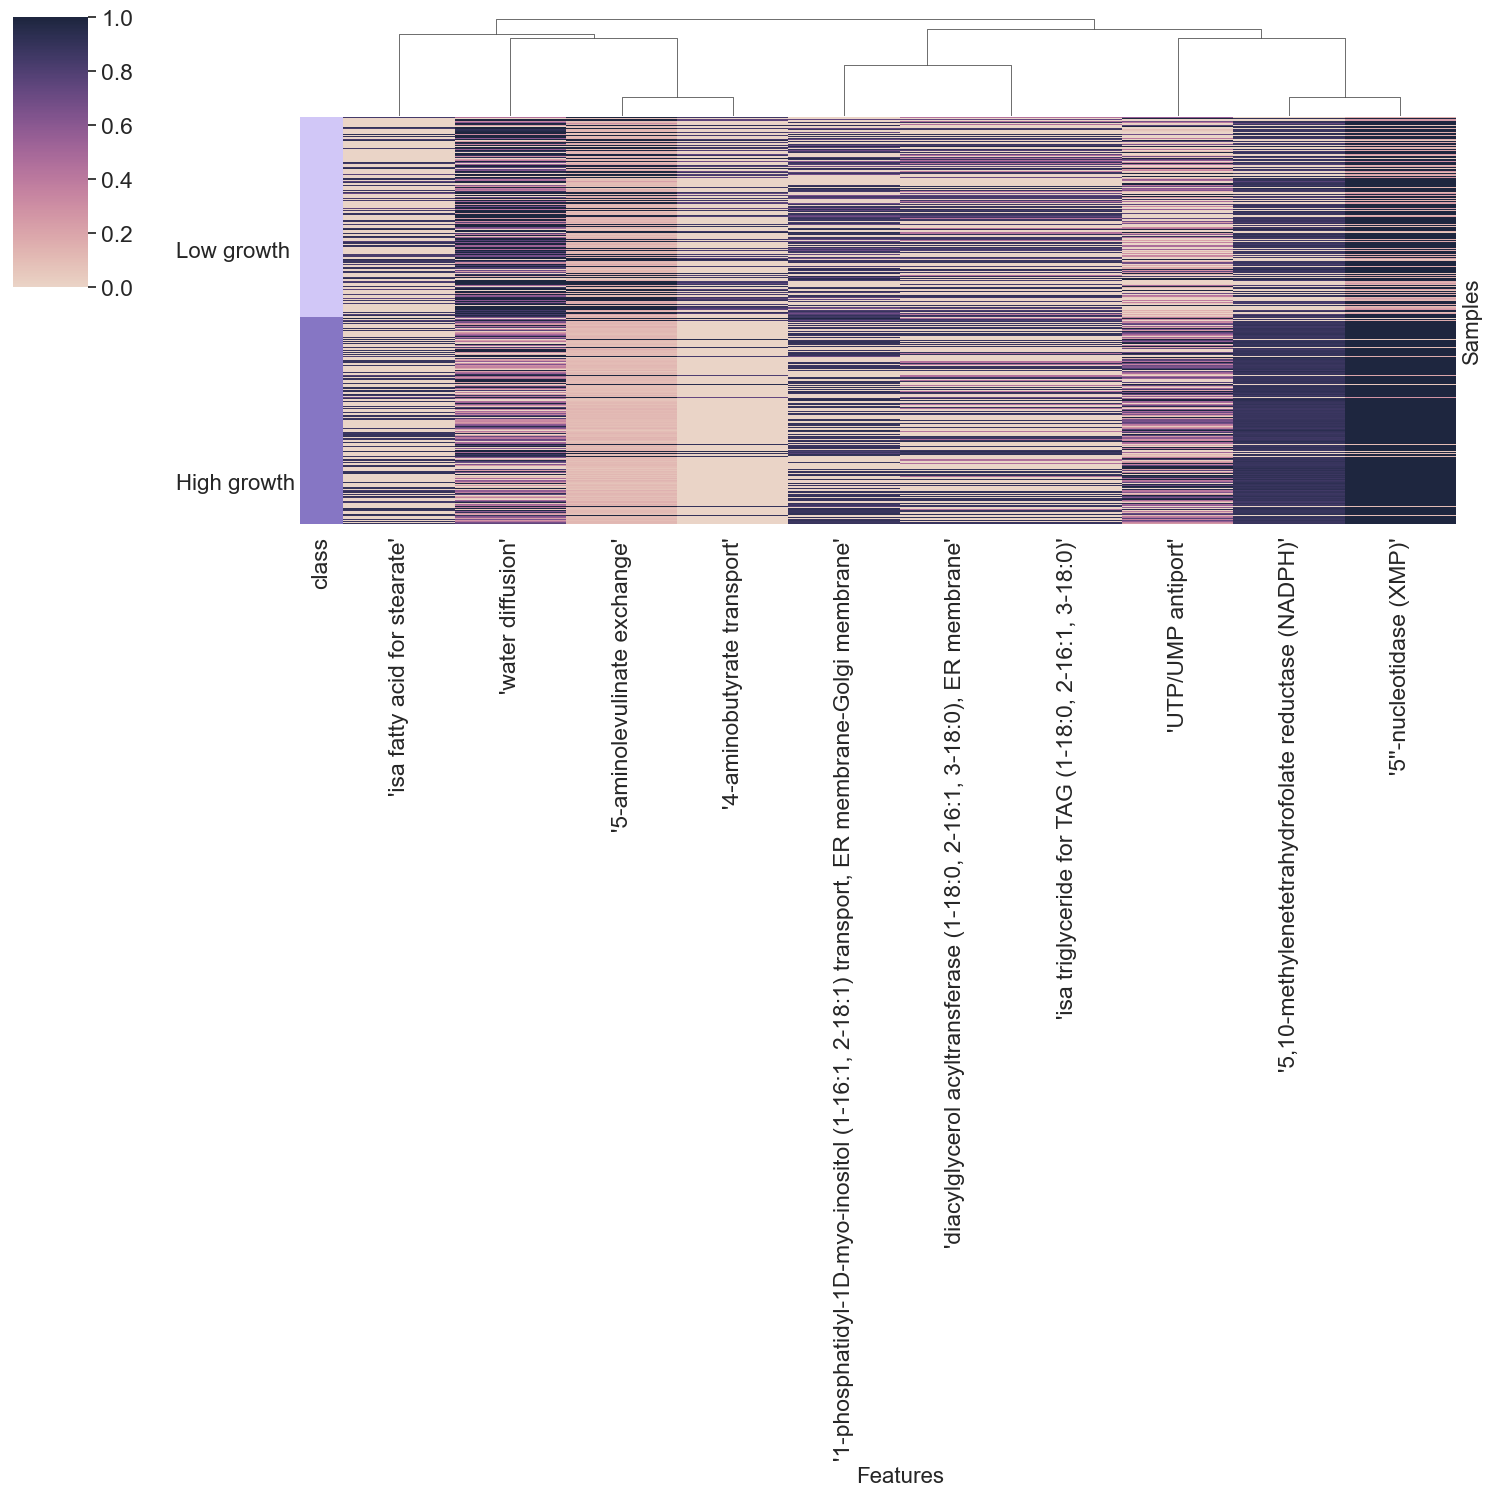

In [271]:
index = y['class'].sort_values().index
indices = lasso_p_f.sort_values('lasso_log_p_f_glpk_30', ascending=False)['rxn_id'][:10]
rxns_names = lasso_p_f.sort_values('lasso_log_p_f_glpk_30', ascending=False)['rxn_name'][:10]
data = fluxes_p[indices]
cols = ['fluxomics' for i in range(data.shape[1])]
col_colors = pd.Series(cols, index=data.columns).map({
    'fluxomics': '#747cc8'
})
index = list(set(index).intersection(set(data.index)))
index = y.loc[index, 'class'].sort_values().index
g = sns.clustermap(data.loc[index, :], row_colors=y.loc[index, 'class'].map({0: '#d1c7f7', 2: '#8676c4'}),
                 figsize=(15, 15), cmap=sns.color_palette("ch:s=-.4,r=.6", as_cmap=True), 
                row_cluster=False,
                xticklabels=rxns_names,
    yticklabels=False)


legend_patches = [
    mpatches.Patch(color='#d1c7f7', label='Low growth'),
    mpatches.Patch(color='#8676c4', label='High growth')
]
ax = g.ax_heatmap

# Add labels for the row colors (Low/High growth)
# Position depends on your plot size and how many samples you have
ax.text(-0.15, 0.67, 'Low growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')
ax.text(-0.15, 0.1, 'High growth', fontsize=16,
        transform=ax.transAxes, verticalalignment='center')

# Remove default legend if present
if g.ax_col_dendrogram.legend_:
    g.ax_col_dendrogram.legend_.remove()

g.ax_heatmap.set_xlabel("Features", fontsize=16)
g.ax_heatmap.set_ylabel("Samples", fontsize=16)
sns.set(font_scale=1.5)